# Introduction to the Qiskit Compiler 

In [1]:
import qiskit
qiskit.__version__

'0.23.3'

## Why we need a compiler

* Despite programming current quantum computers at the per bit level this is still an abstraction over the capabilities of the hardware
* Current quantum computers have numerous limitations
* The Qiskit compiler's job is to take the virtual ideal circuit and translate it to a physical circuit that is optimized and capable of running on the actual device

In [2]:
from qiskit import transpile, QuantumCircuit
from qiskit_ibm_provider import IBMProvider

In [3]:
provider = IBMProvider()

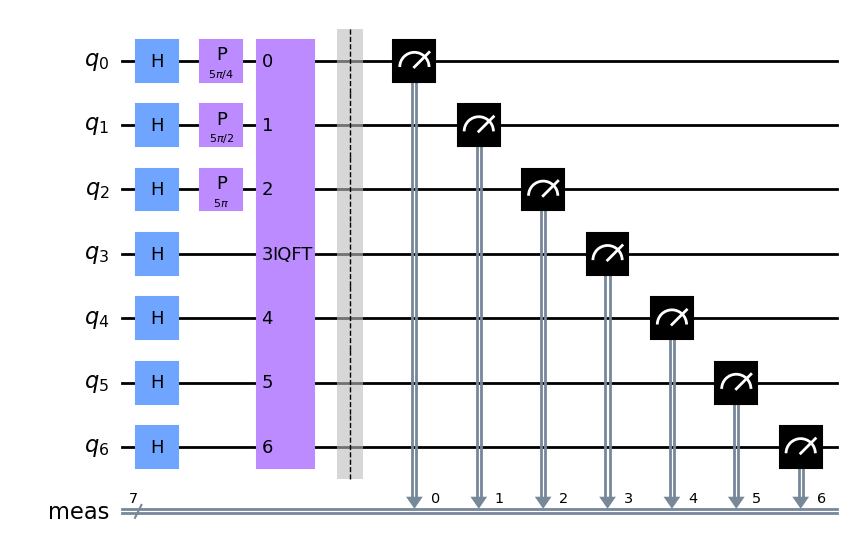

In [4]:
from math import pi

from qiskit.circuit.library import QFT

backend = provider.get_backend("ibmq_jakarta")

# Build QFT circuit with expected result 1111101
nqubits = 7
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.append(QFT(nqubits, do_swaps=False, inverse=True), list(range(7)))
qc.measure_all()

qc.draw('mpl', fold=-1)

In [5]:
tqc_bad = transpile(qc, backend, optimization_level=0, routing_method="basic", initial_layout=[4, 2, 0, 6, 1, 3, 5], seed_transpiler=42)
tqc_good = transpile(qc, backend, optimization_level=3, seed_transpiler=42)

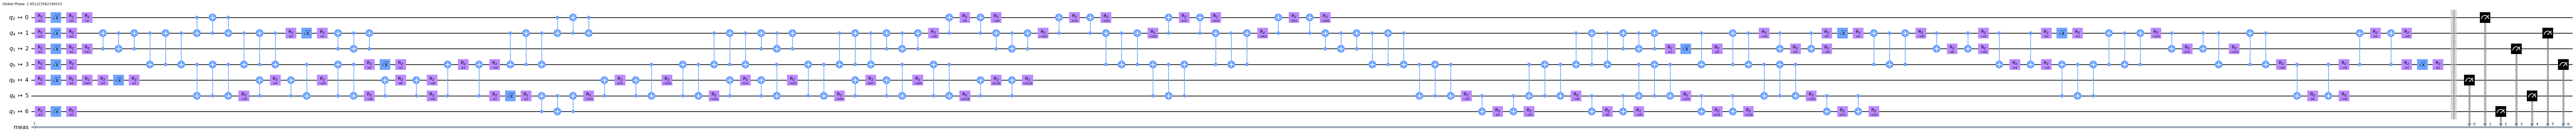

In [6]:
tqc_bad.draw('mpl', fold=-1)

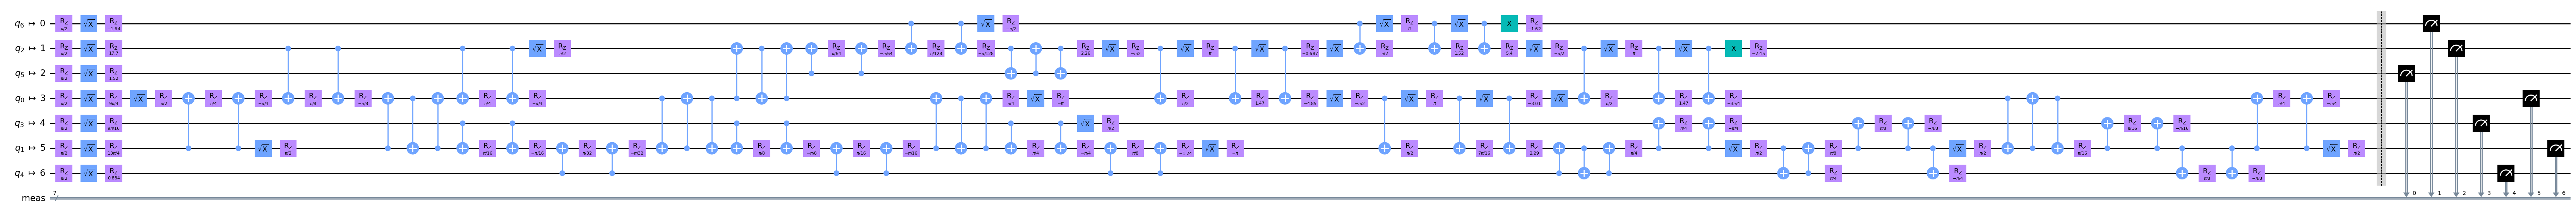

In [7]:
tqc_good.draw('mpl', fold=-1)

In [8]:
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

sim = AerSimulator.from_backend(backend)
sim.set_options(seed_simulator=42_2023)

In [9]:
bad_job = sim.run(tqc_bad, shots=10_000)
bad_counts = bad_job.result().get_counts()
print("With bad compiler settings")
print(f"Got expected result: {100 * (bad_counts['1111101'] / 10_000)} % of the time")

With bad compiler settings
Got expected result: 11.25 % of the time


In [10]:
good_job = sim.run(tqc_good, shots=10_000)
good_counts = good_job.result().get_counts()
print("With good compiler settings")
print(f"Got expected result: {100 * (good_counts['1111101'] / 10_000)} % of the time")

With good compiler settings
Got expected result: 21.15 % of the time


## Constraints on hardware

### Supported Instructions

Hardware only supports a subset of gates and other operations by default.

In [11]:
backend.operation_names

['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay', 'if_else']

### Qubit Connectivity

For superconducting qubits the ability to run operations. On the physical device there is only connectivity between certain qubits:

![ibmqx2-labeled.png](imgs/ibmqx2-labeled.png)

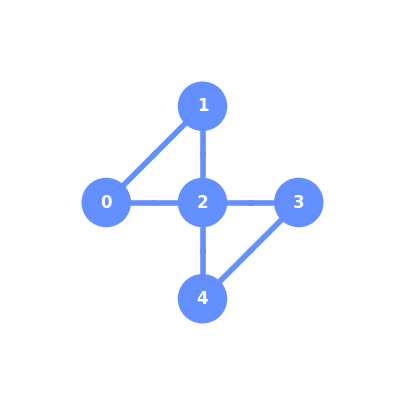

In [12]:
from qiskit.providers.fake_provider import FakeYorktownV2
from qiskit.visualization import plot_gate_map

# Look at a graph view of the same die photo

plot_gate_map(FakeYorktownV2())

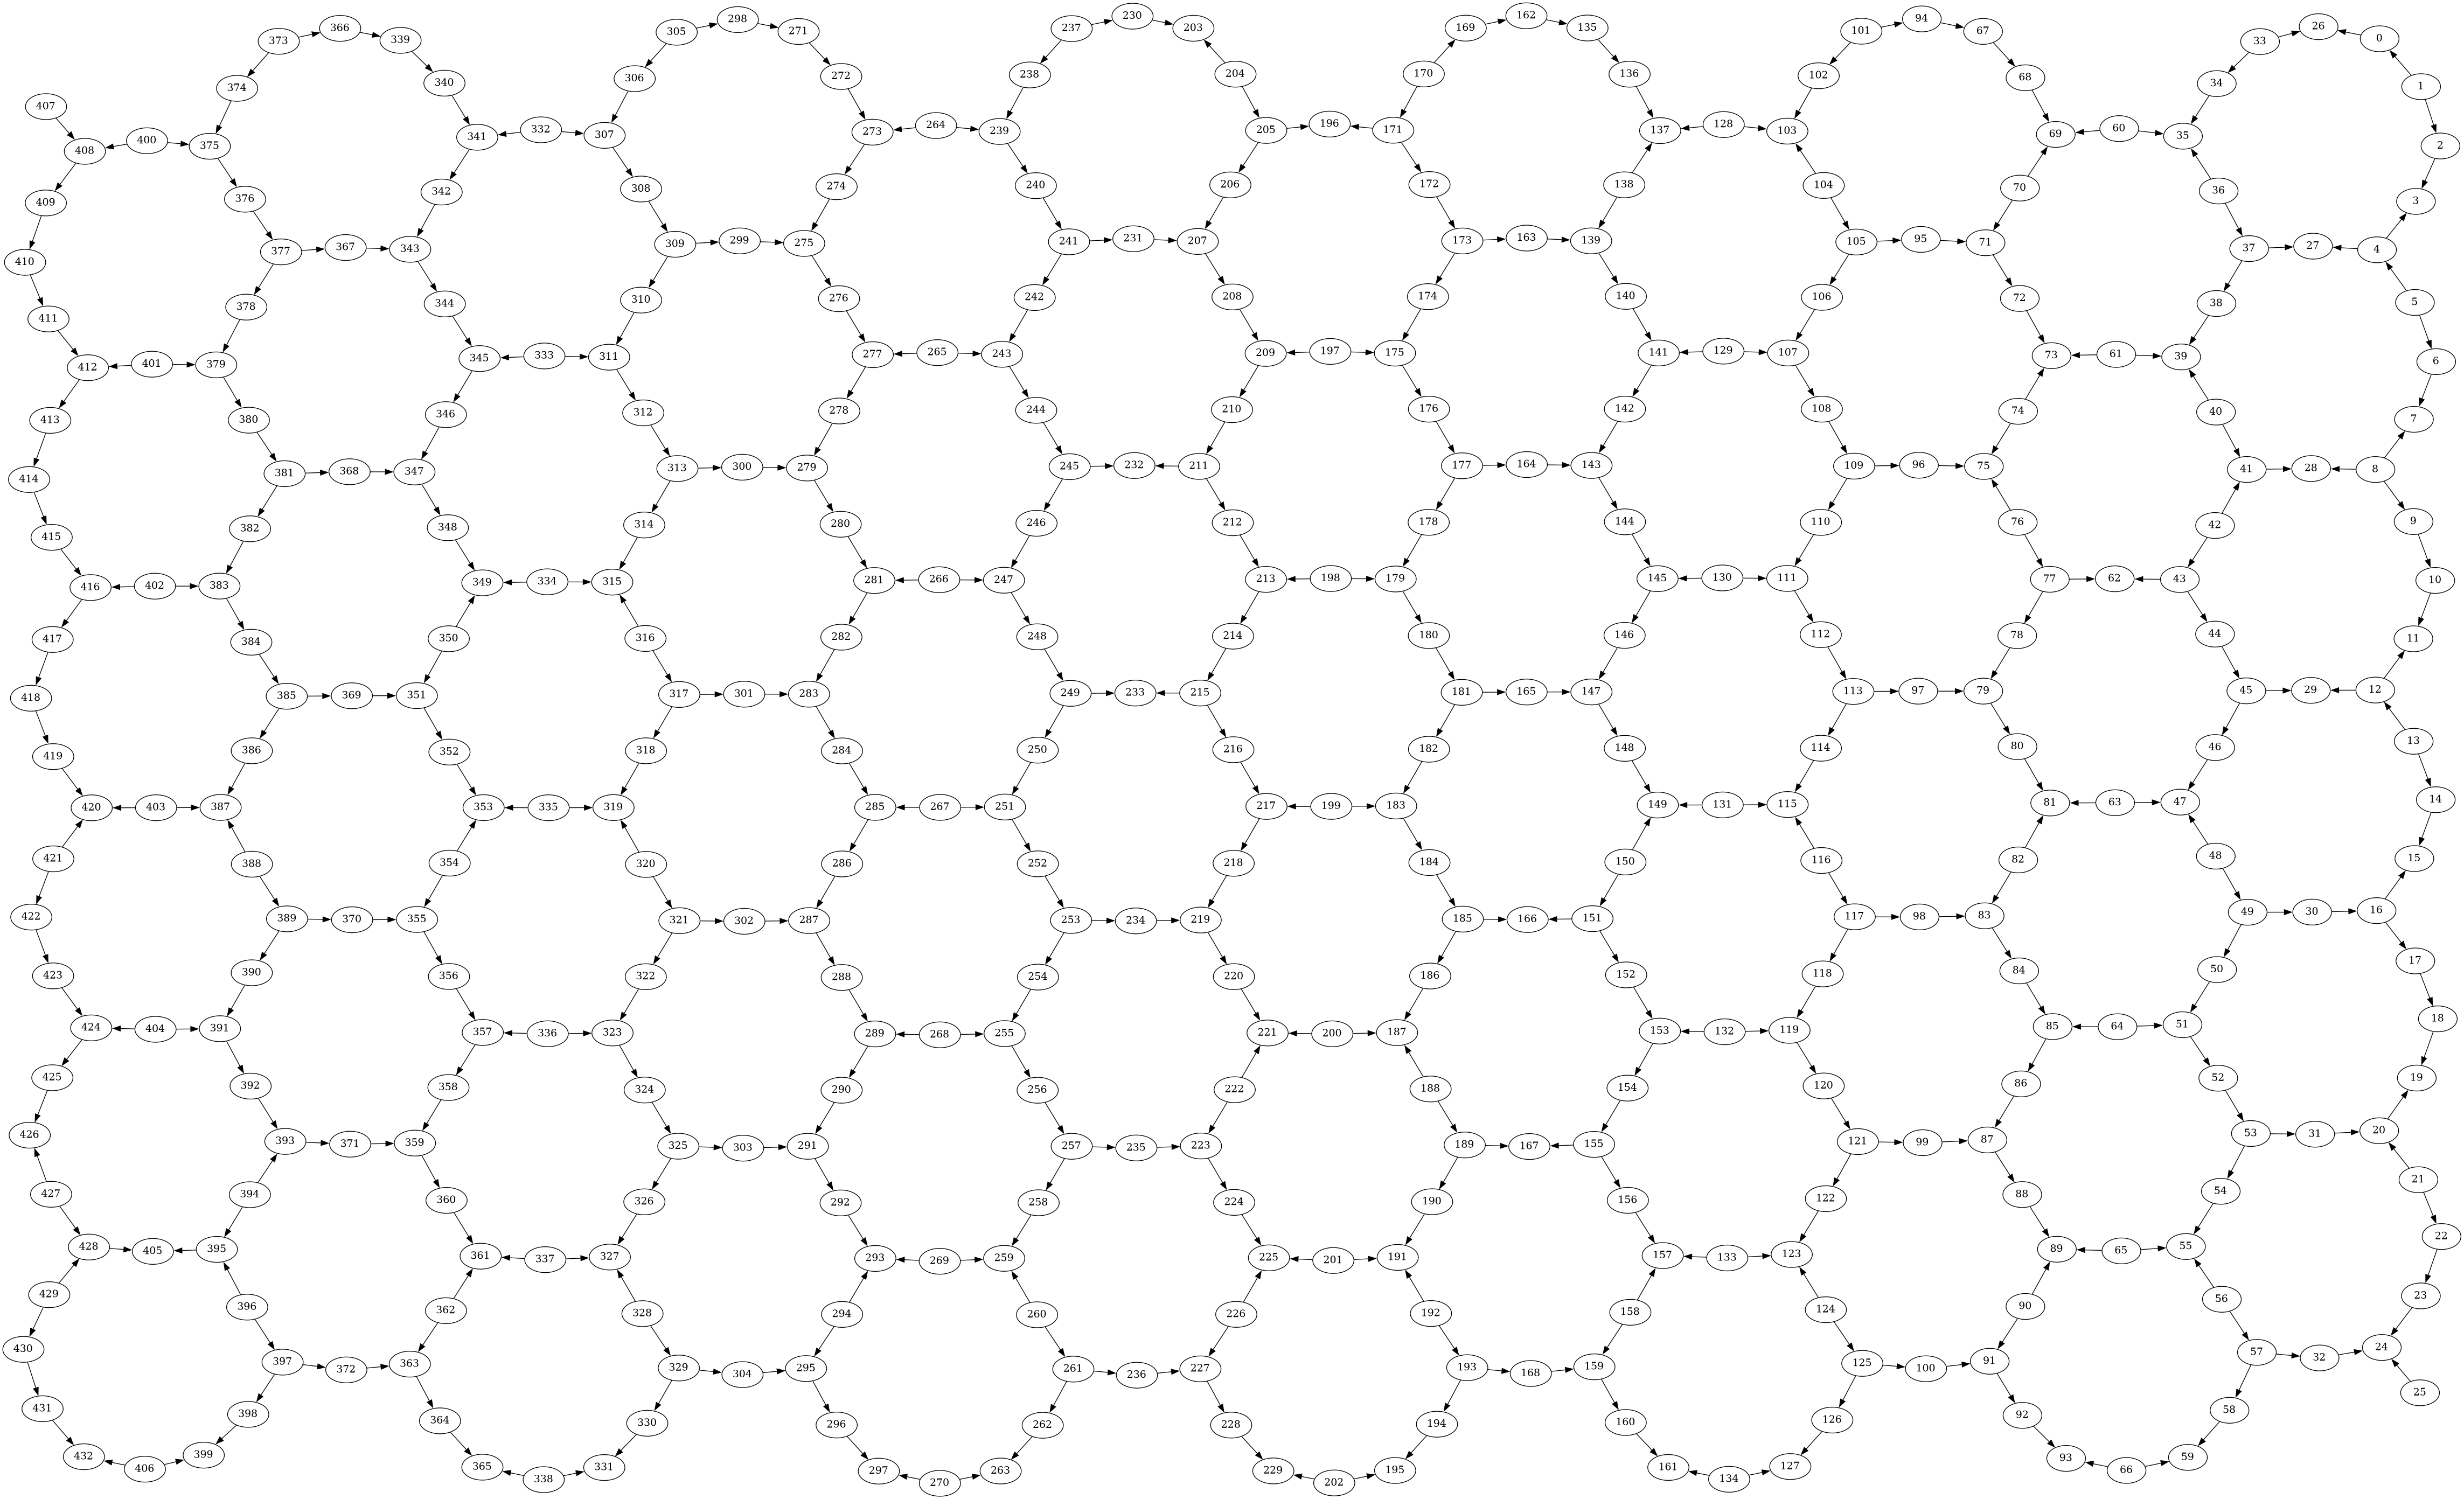

In [13]:
# Easy to reason about with 5 qubits, not as easy with:

backend = provider.get_backend("ibm_seattle")
backend.coupling_map.draw()

## Noise/Errors

Every operation on current quantum computers are sources of noise and error

* Gate errors
* Readout errors
* Decoherence


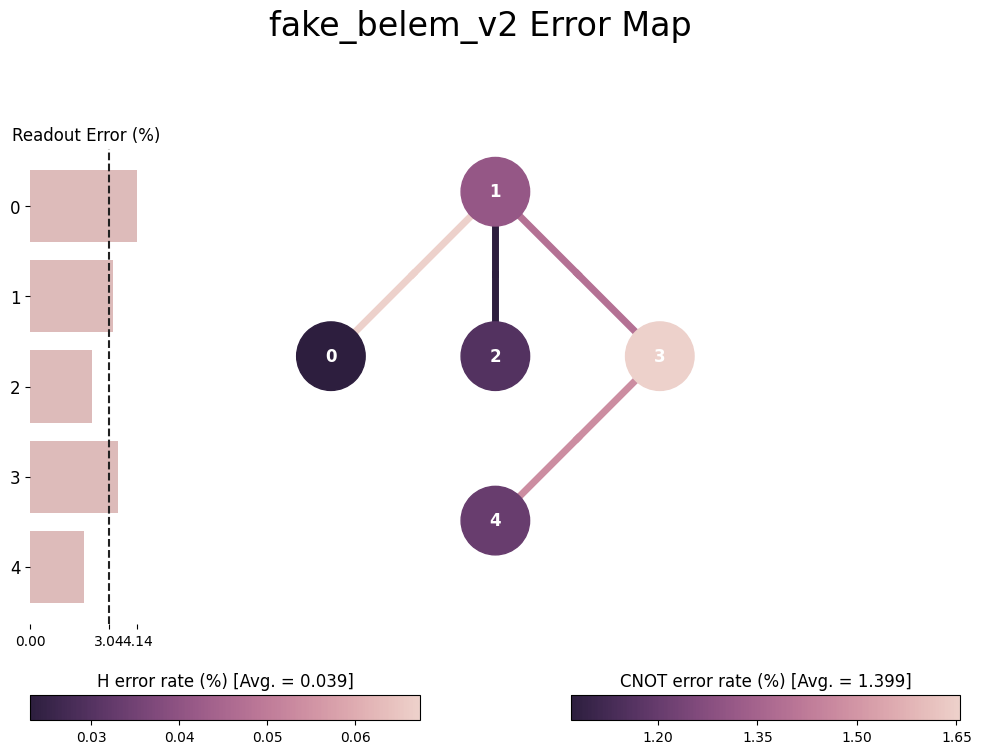

In [14]:
from qiskit.visualization import plot_error_map
from qiskit.providers.fake_provider import FakeBelemV2

plot_error_map(FakeBelemV2())

![variability.png](imgs/variability.png)

## Modelling the Constraints of Hardware

For compilation the `Target` data structure is used to model the constraints of a backend.
Each `Backend` object in Qiskit creates a `Target` which is used by `transpile()` to understand the constraints of the target backend during compilation.

In [15]:
from qiskit.transpiler import Target
from qiskit.providers.fake_provider import FakePrague

In [16]:
backend = FakePrague()
# Print the contents of the target which shows all the constraints
print(backend.target)

Target
Number of qubits: 33
Instructions:
	id
		(0,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.0002389040461508991
		(1,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.0003044545523649043
		(2,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.0003202191435487749
		(3,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00017909819586198696
		(4,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00014955012784294565
		(5,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00021300316461249992
		(6,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00020247519260627907
		(7,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00012946361450120048
		(8,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00012864606509348136
		(9,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.0003045229420625869
		(10,):
			Duration: 2.4888888888888885e-08 sec.
			Error Rate: 0.00012573921953873613


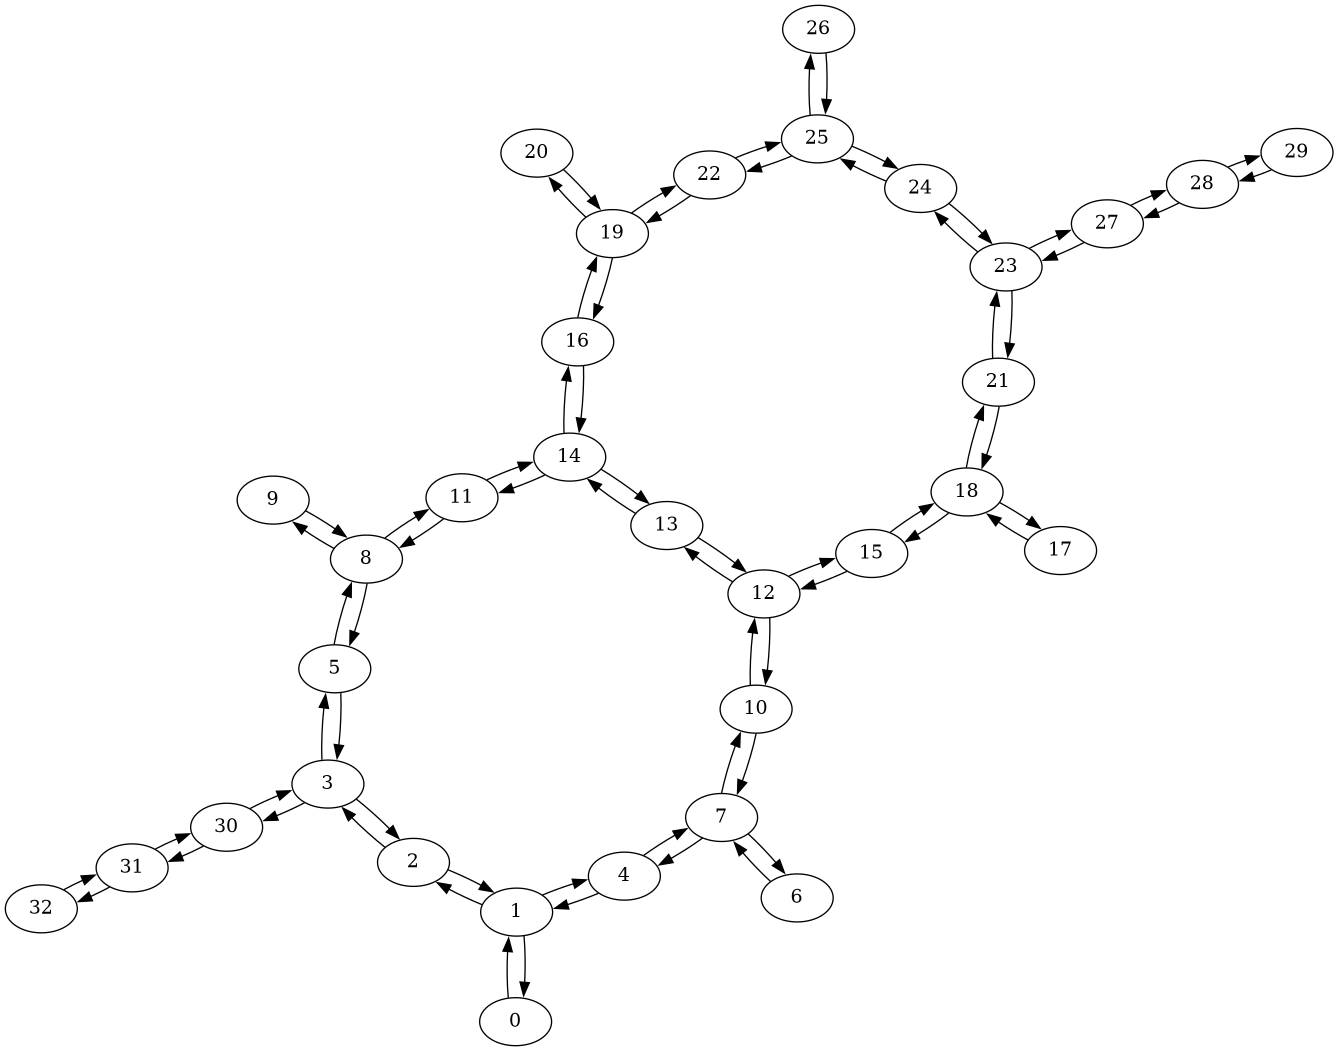

In [17]:
# Visualize the qubit connectivity
backend.target.build_coupling_map().draw()

In [18]:
# Print the names of the supported instruction
print(list(backend.target.operation_names))

['id', 'rz', 'sx', 'x', 'cz', 'reset', 'measure', 'delay']


In [19]:
# Check if an operation is supported
print(
    "CZ on (0,1) supported: "
    f"{backend.target.instruction_supported('cz', qargs=(1, 0))}"
)
print(
    "CX on (0,1) supported: "
    f"{backend.target.instruction_supported('cx', qargs=(0, 1))}"
)

CZ on (0,1) supported: True
CX on (0,1) supported: False


In [20]:
# Get instruction properties
backend.target['cz'][(0, 1)]

InstructionProperties(duration=6.755555555555556e-08, error=0.0022823511524740214, calibration=None)

## Working with the `transpile()`

The `transpile()` function is the primary entry point for compiling quantum circuits for hardware.

It's basic usage is you give it circuit(s) and a target backend. It will return the compiled `QuantumCircuit`(s) for that target backend. For example:

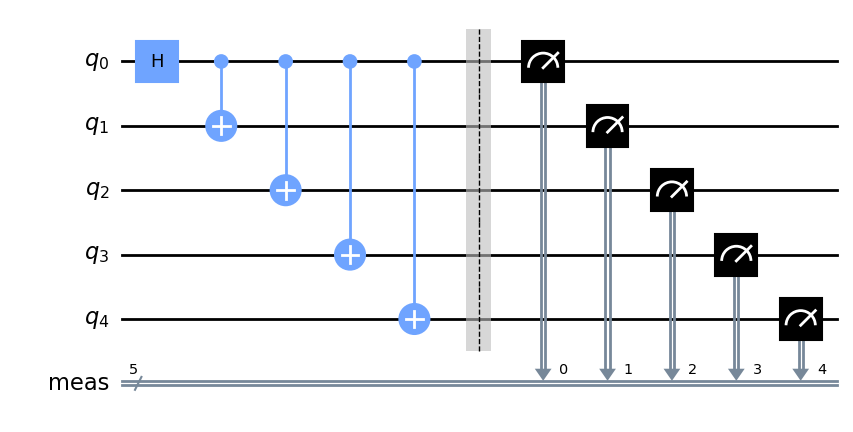

In [21]:
circuit = QuantumCircuit(5)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(0, 4)
circuit.measure_all()
circuit.draw('mpl')

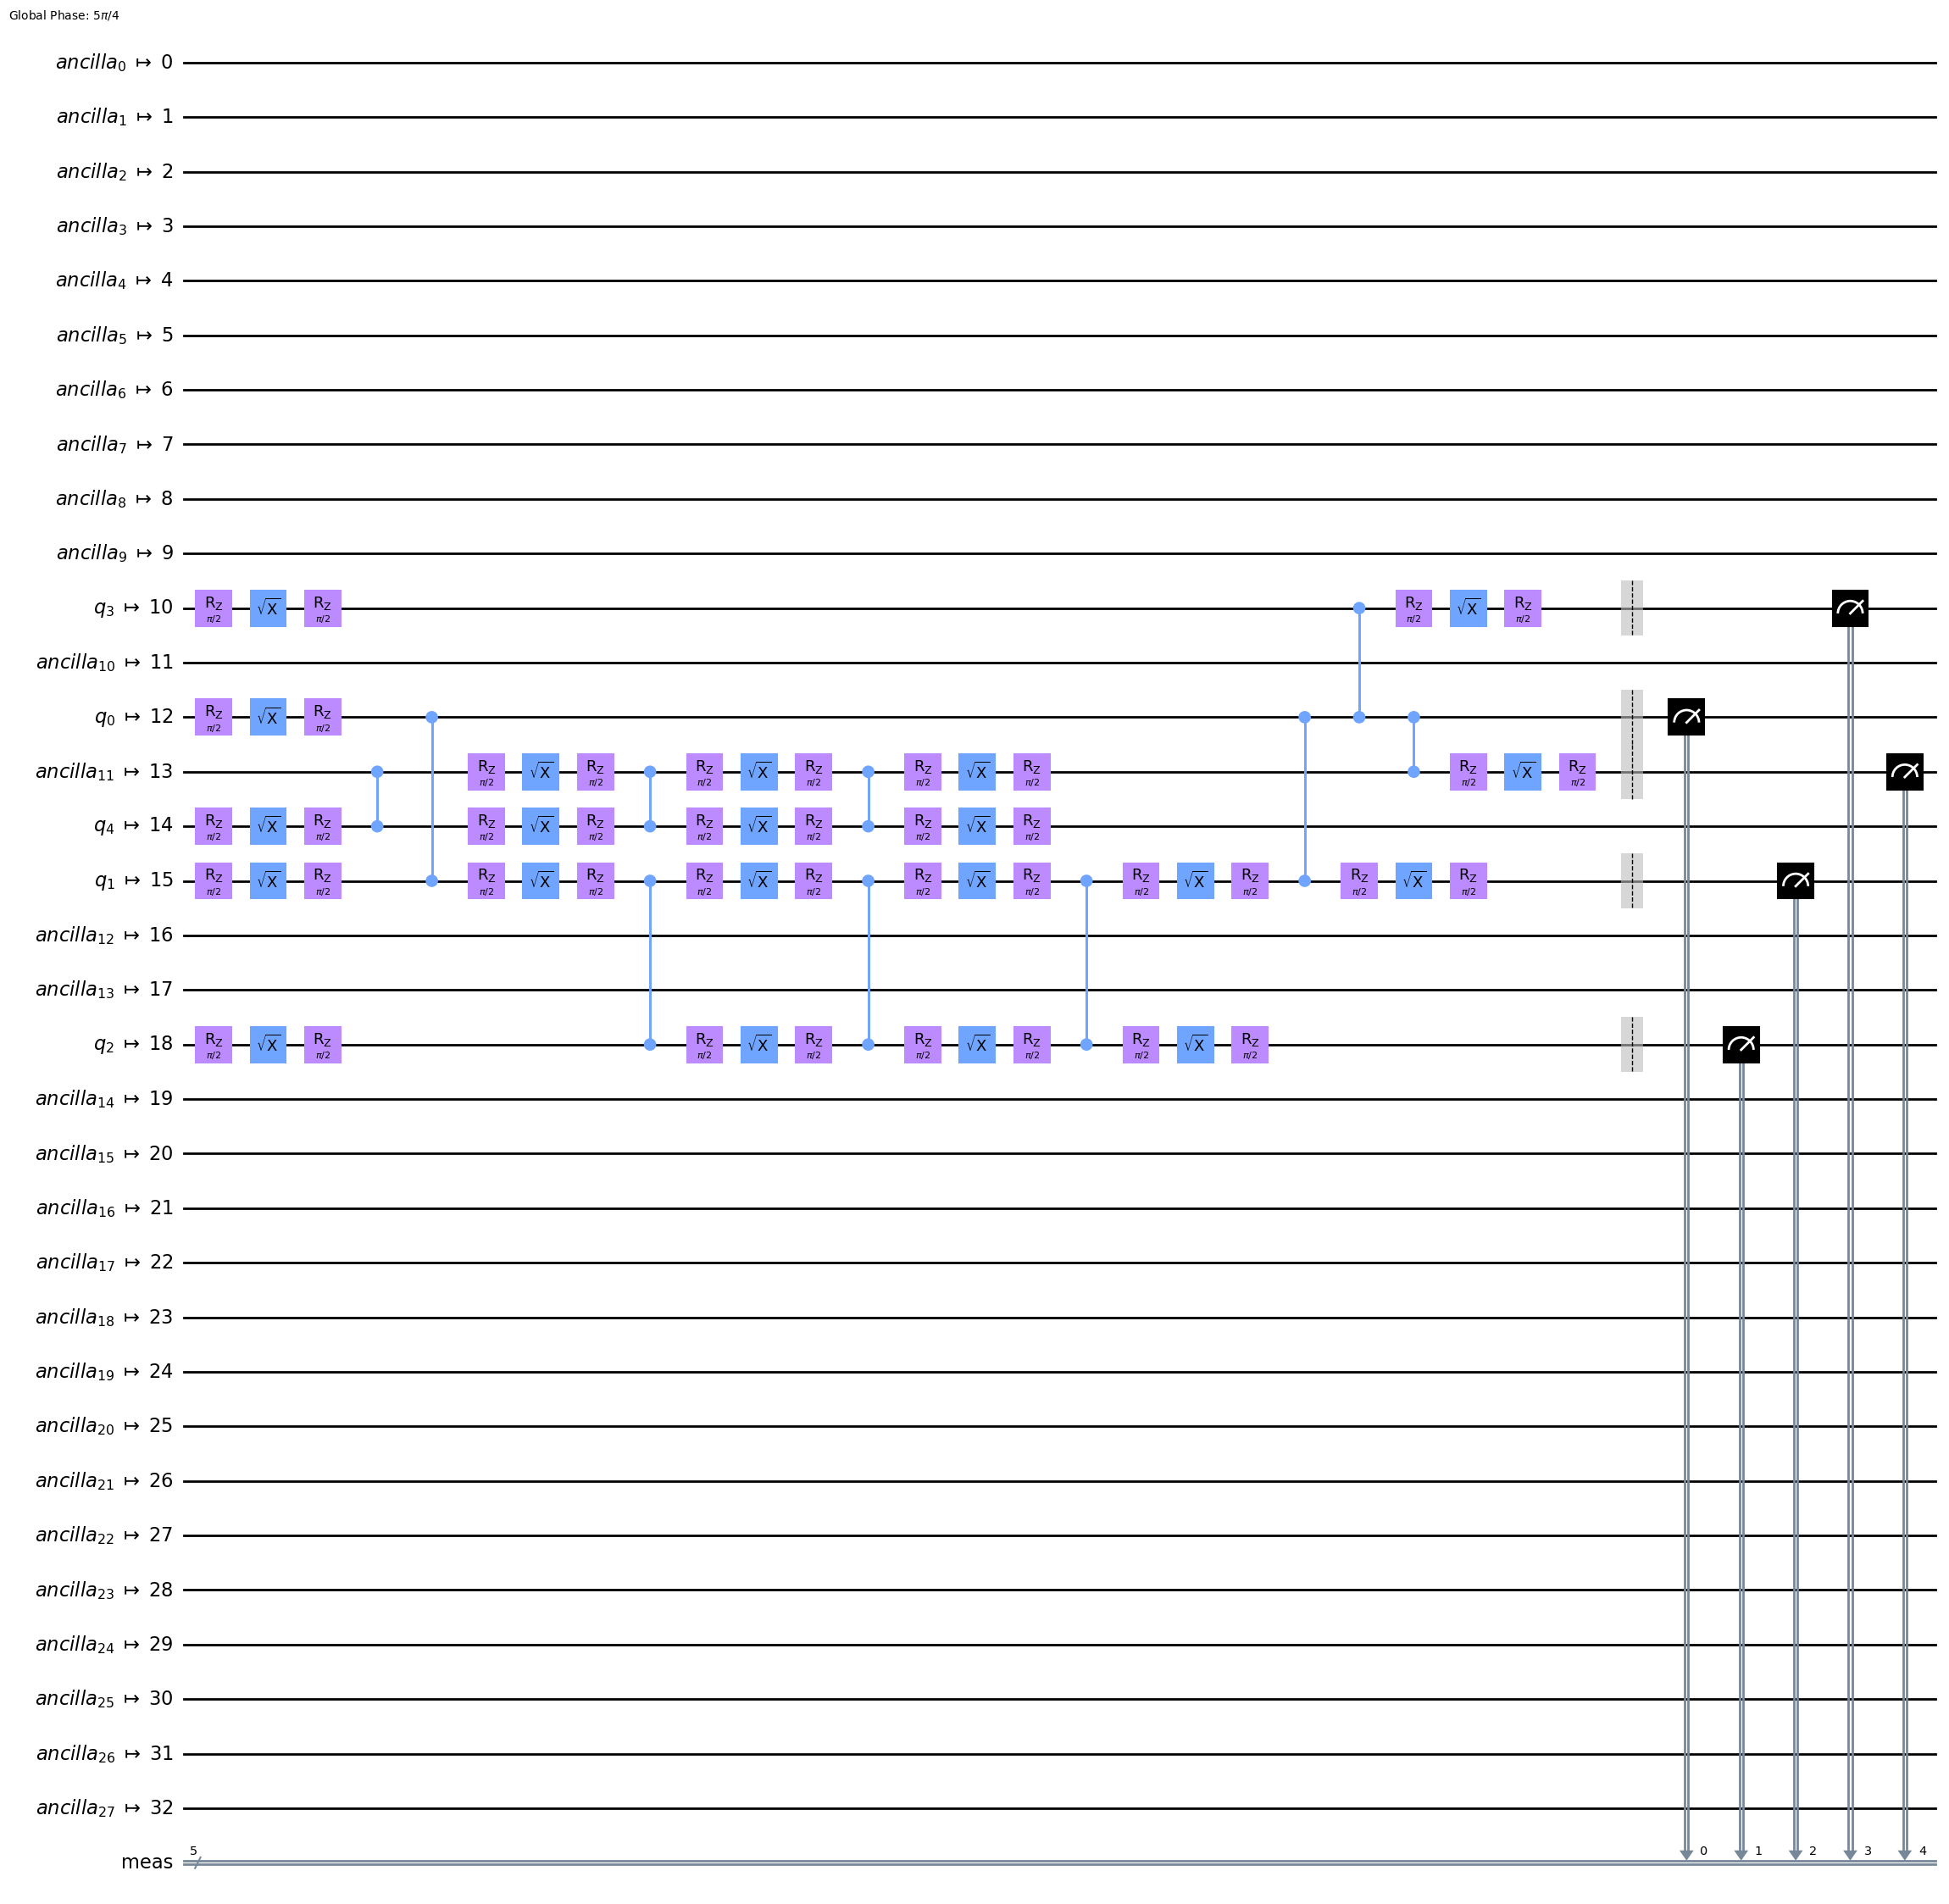

In [22]:
transpile(circuit, backend).draw('mpl', fold=-1)

## Optimization level

The `optimization_level` argument is used to specify the degree of computational effort you want to use to try and optimize the circuit. Ranges from 0 (no optimization) to 3 (most effort). Increasing the number increases the effort the transpiler will spend trying to optimize the input.

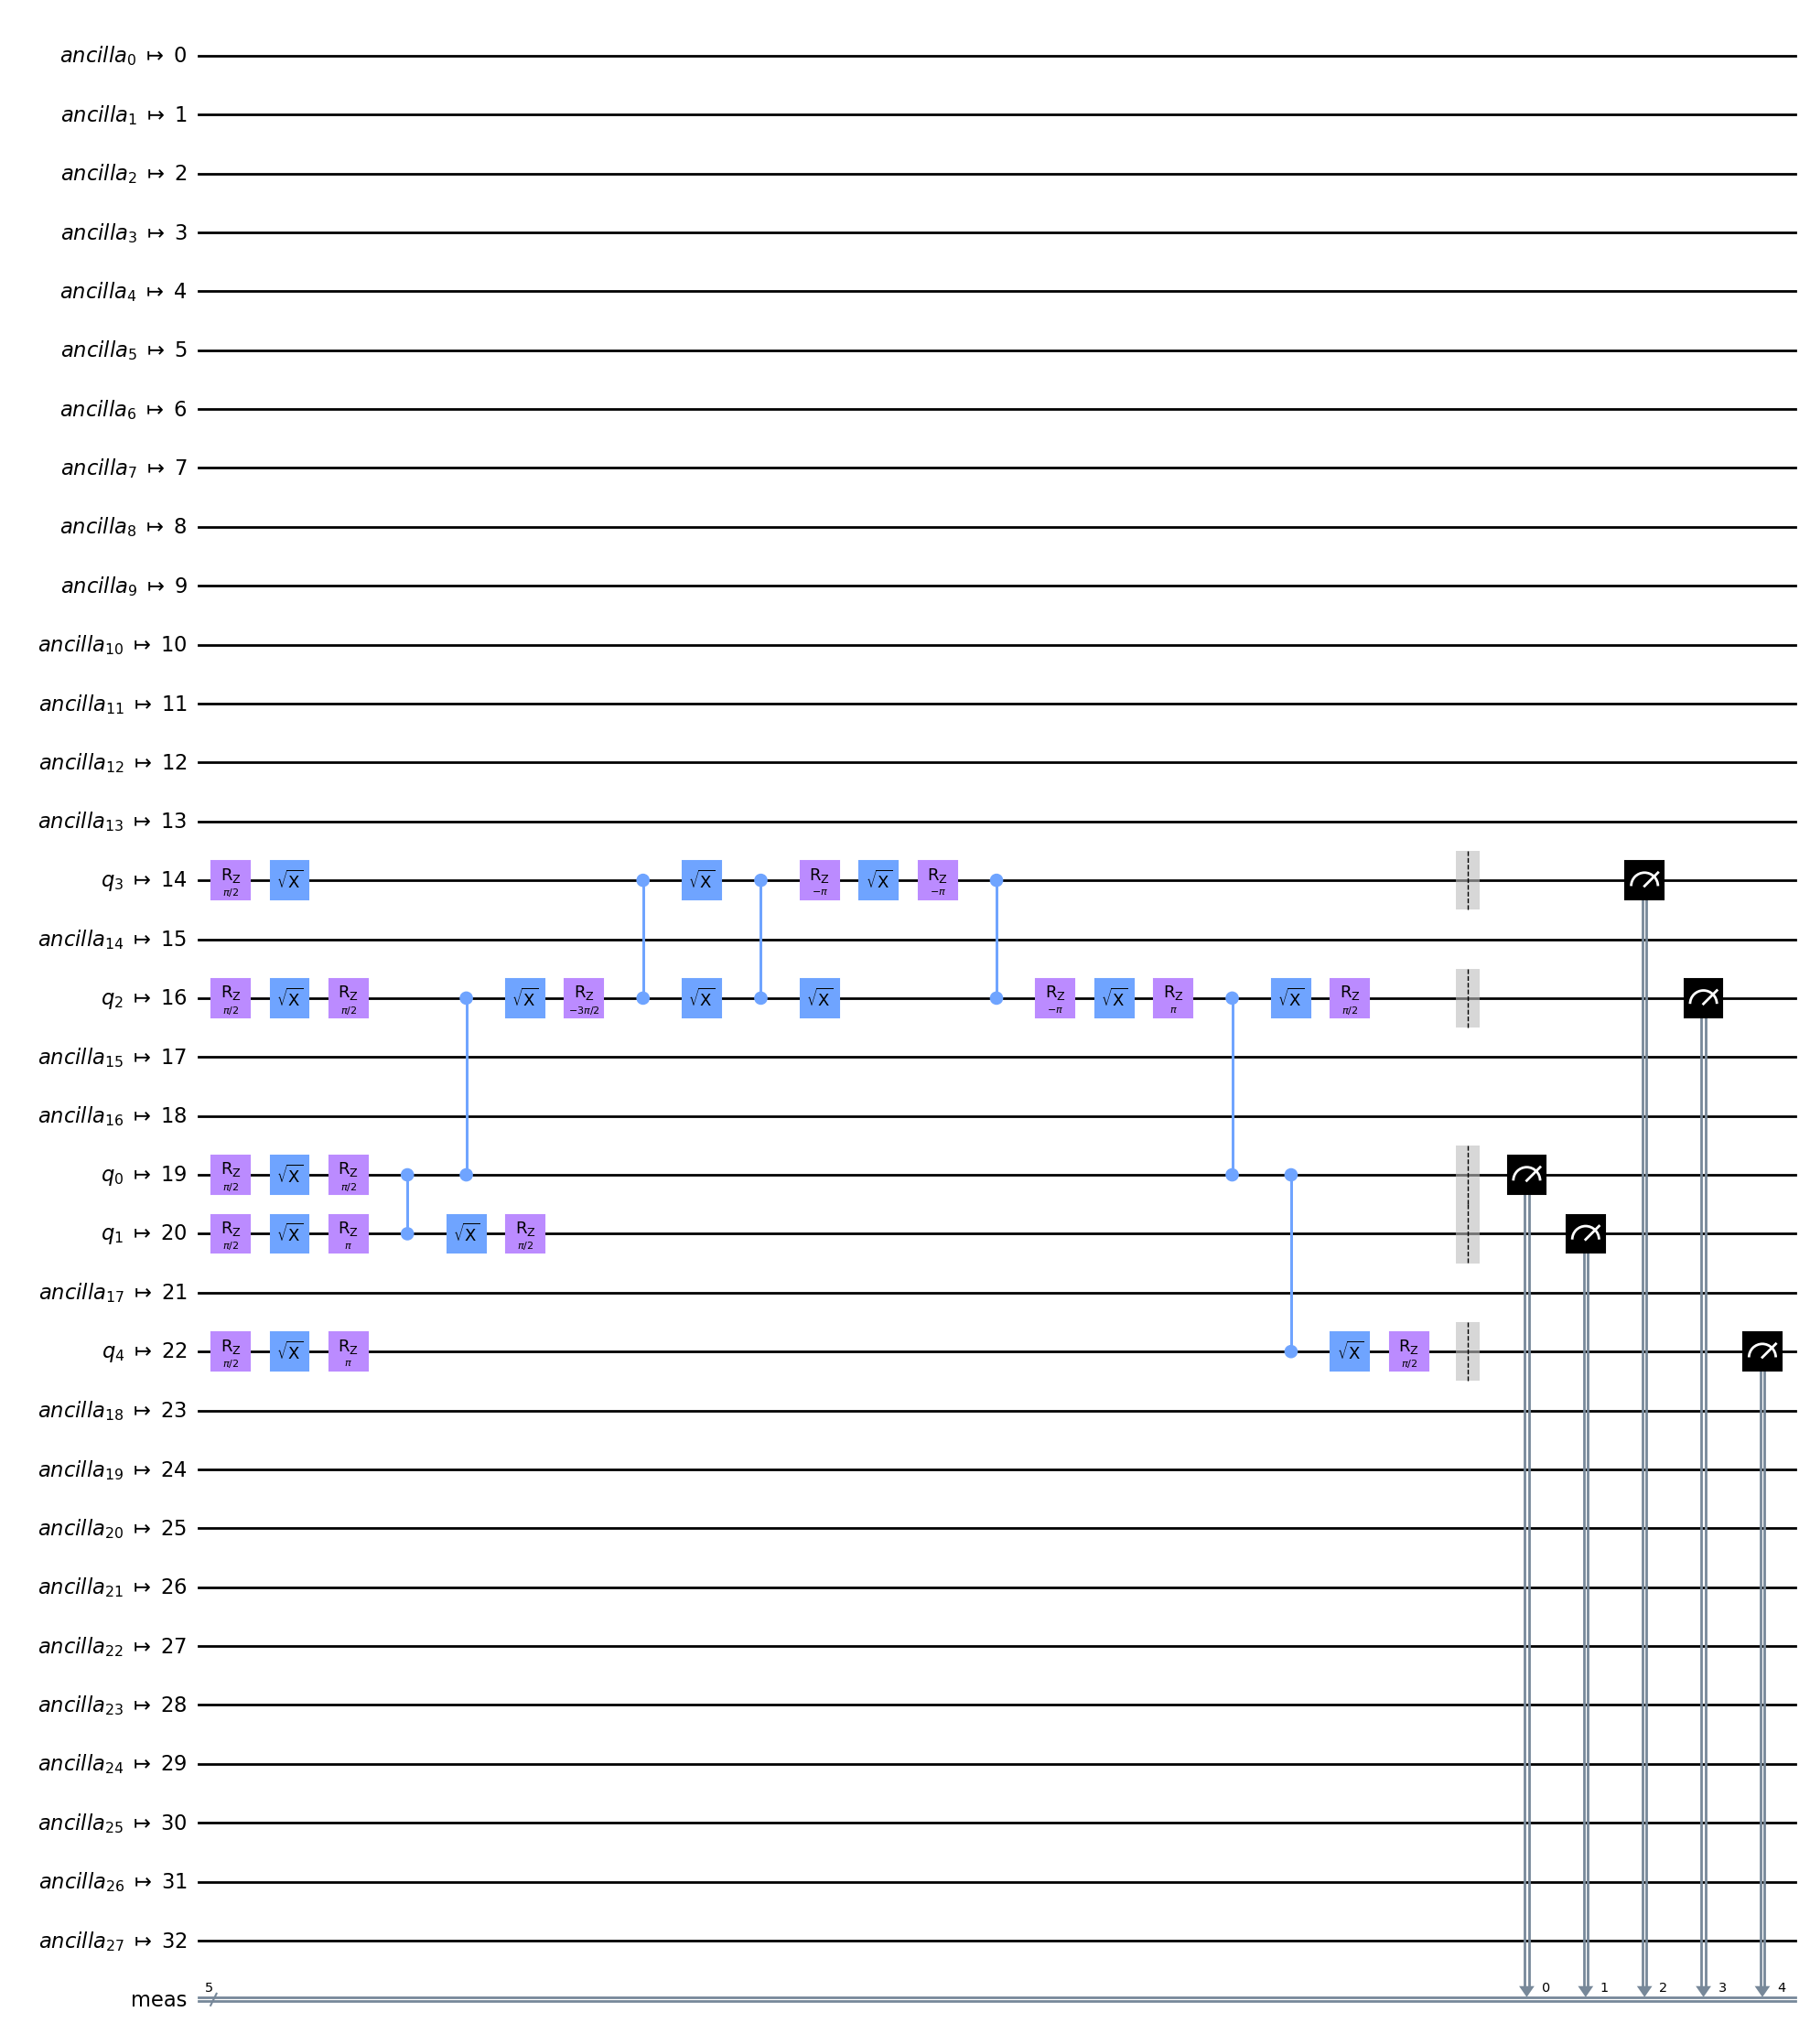

In [23]:
# Set optimization_level
transpile(circuit, backend, optimization_level=3).draw('mpl', fold=-1)

In [24]:
# Runtime increases with each optimization level:
for i in range(4):
    print(f"Time with optimization level: {i}")
    %timeit -n2 transpile(circuit, backend, optimization_level=i)

Time with optimization level: 0
16 ms ± 728 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)
Time with optimization level: 1
18.4 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
Time with optimization level: 2
28.1 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
Time with optimization level: 3
41.2 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


## Stages of a typical transpile pipeline

- **Init** - Initial passes, typically consists of any logical optimization and any transforms necessary to run later stages
- **Layout** - Runs the layout pass to map virtual circuit qubits to the physical qubits on the hardware
- **Routing** - Inserts `SWAP` gates into the circuit where necessary to make up for a lack of connectivity
- **Translation** - Translate all circuit operations into the target's native operations
- **Optimization** - Run any optimization and simplification on the circuit, typically run in a loop to continually optimize the circuit until it reaches a fixed size
- **Scheduling** - Optional scheduling stage that times the circuit and inserts delay operations or dynamical decoupling sequences to account for all slack time in the circuit

## Layout

This stage is used to map the virtual qubits circuit qubits to the physical qubits on the device.

![layout.png](imgs/layout.png)

Built-in to Qiskit `transpile()` there are several passes to do this:

* `TrivialLayout` (`"trivial"`)- Maps qubit 0 to physical qubit 0, 1->1, 2->2, etc.
* `DenseLayout` (`"dense"`) - Finds the subgraph with densest connectivity in the connectivity graph and select a permutation of that as the layout.
* `VF2Layout` - Searches for a perfect layout as a subgraph isomorphism problem and if a solution exists will pick the layout with the lowest error rate (as reported by the backend).
* `VF2PostLayout` - Selects a new layout after routing stage based on error rates on target to try and maximize fidelity based on calibration data.
* `SabreLayout` (`"sabre"`) - A heuristic method that use a routing method to find a layout with minimal swaps required.
* `NoiseAdaptiveLayout` (`"noise_adaptive"`) - Uses the calibration data to find the lowest noise qubits to run the circuit on.

(several others are also included but they've largely been superseded by these passes)

You can use the `layout_method` argument on `transpile()` to change the layout used. Using argument will disable `VF2Layout` and `VF2PostLayout`.

In [25]:
from qiskit.providers.fake_provider import FakeBelemV2
backend = FakeBelemV2()

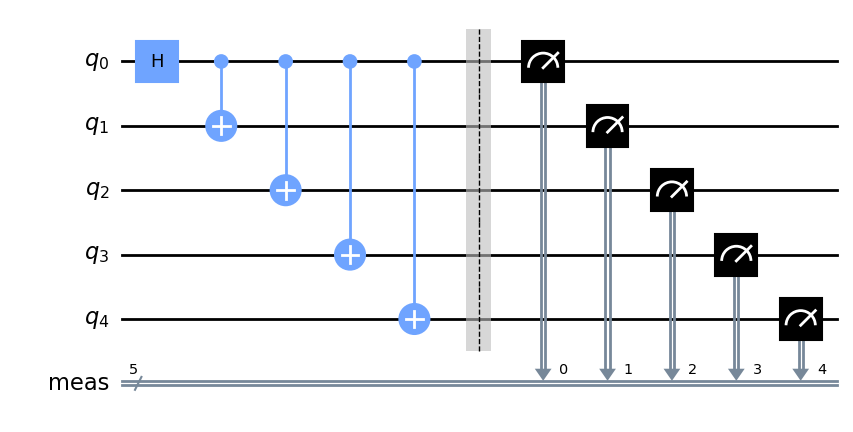

In [26]:
circuit.draw('mpl')

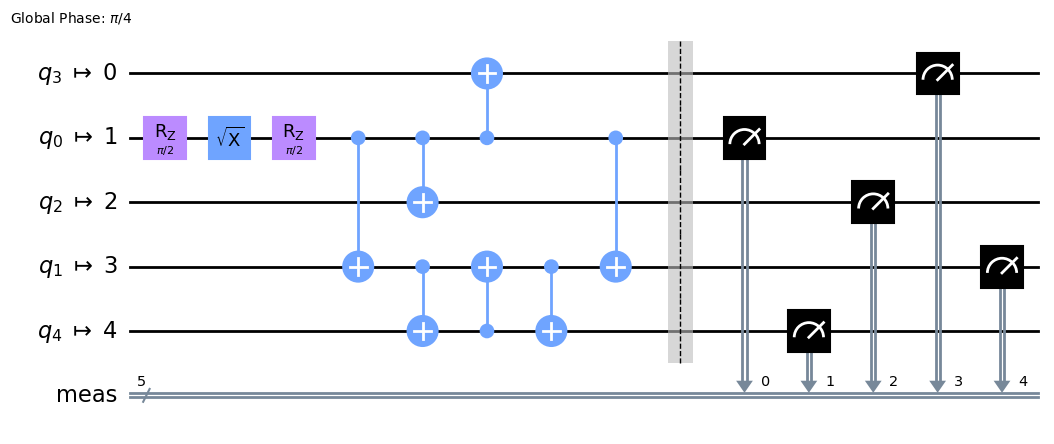

In [27]:
transpile(circuit, backend).draw('mpl')

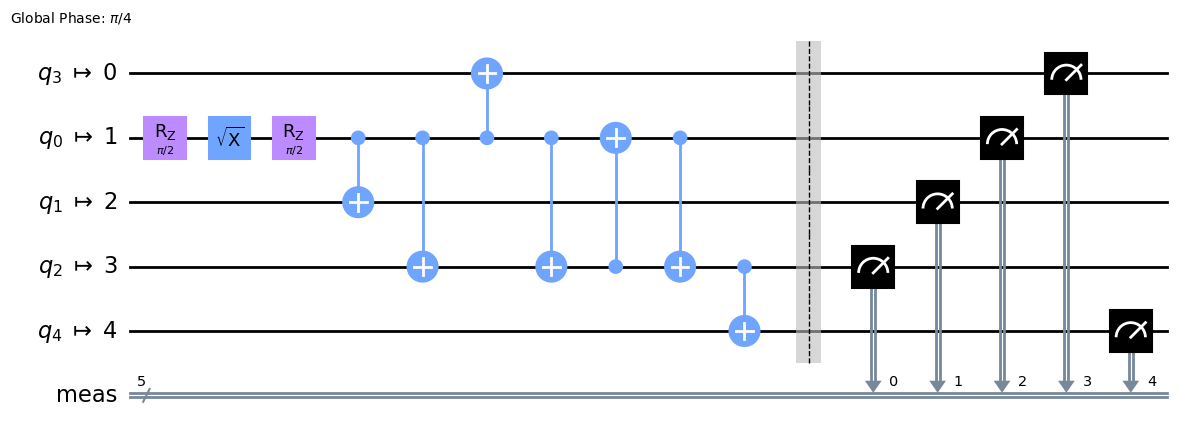

In [28]:
transpile(circuit, backend, layout_method='sabre').draw('mpl')

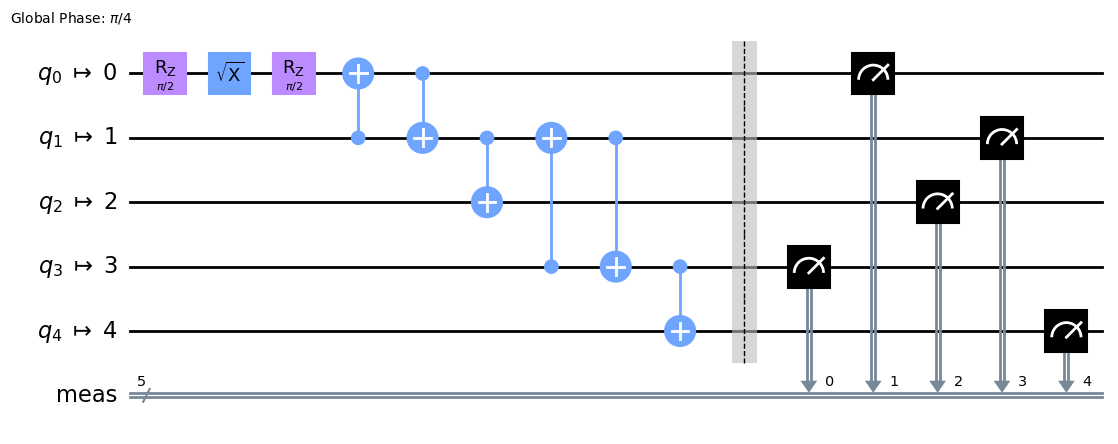

In [29]:
transpile(circuit, backend, layout_method='trivial').draw('mpl')

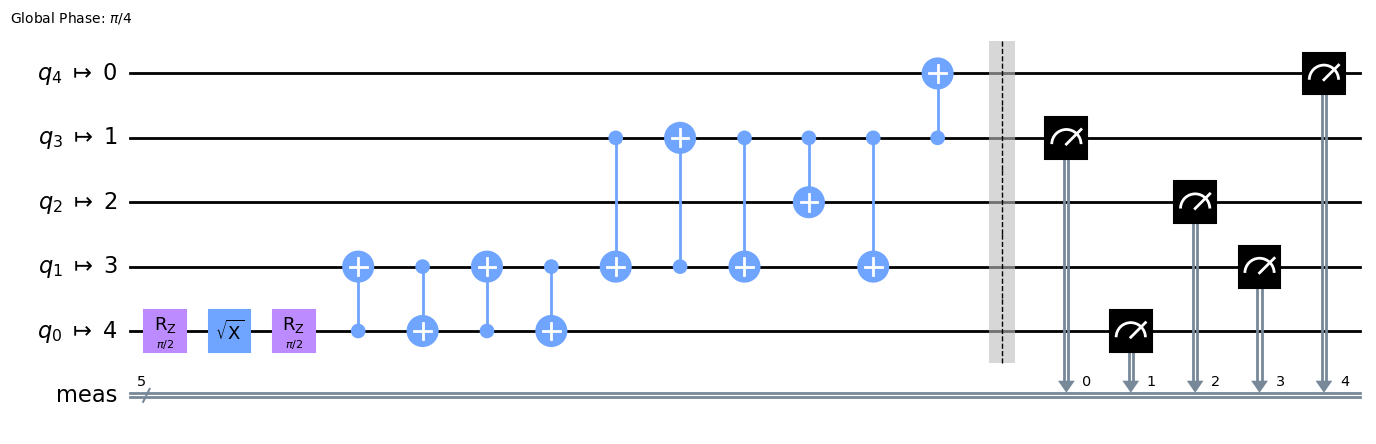

In [30]:
transpile(circuit, backend, layout_method='dense').draw('mpl')

## Manual Layout

You can also specify the layout manually by using the `initial_layout` argument. This supersedes the `layout_method` if both are set.

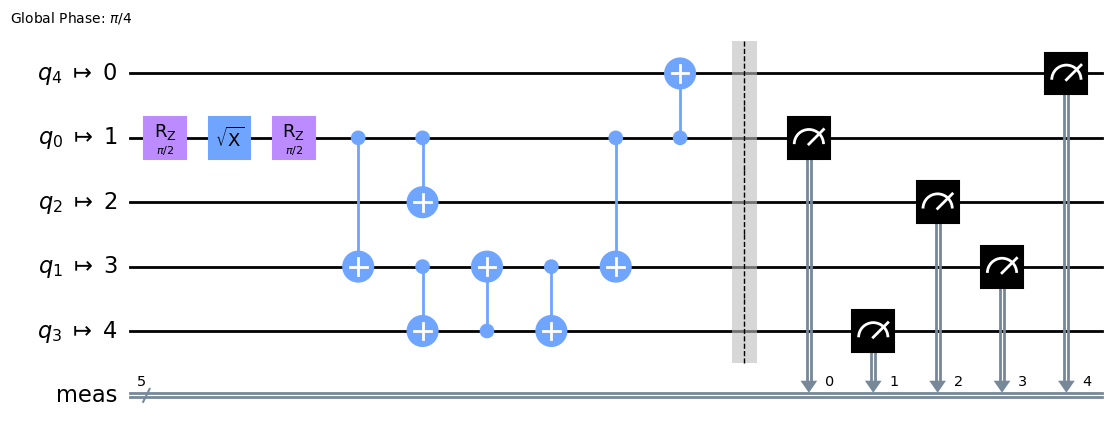

In [31]:
transpile(circuit, backend, initial_layout=[1, 3, 2, 4, 0]).draw('mpl')

## Routing

The routing stage is used to make up for insufficient connectivity on the target by inserting SWAP gates to move state 

Included in Qiskit are several different passes to do this

* `basic` - Iterates over DAG when it encounters a finds shortest path between nodes
* `stochastic` - Randomized algorithm that tries random trials of swaps at each layer and selects the swap to insert based on a heuristic score
* `sabre` - Algorithm that applies a heuristic score (basic algorithm is described in: https://arxiv.org/pdf/1809.02573.pdf but Qiskit's implementation has built on top of this)
* `lookahead` - Uses a beam search over possible SWAP combinations (described in: https://medium.com/qiskit/improving-a-quantum-compiler-48410d7a7084)
* `none` - Error if routing is required

`routing_method` argument is used to select which method to use.

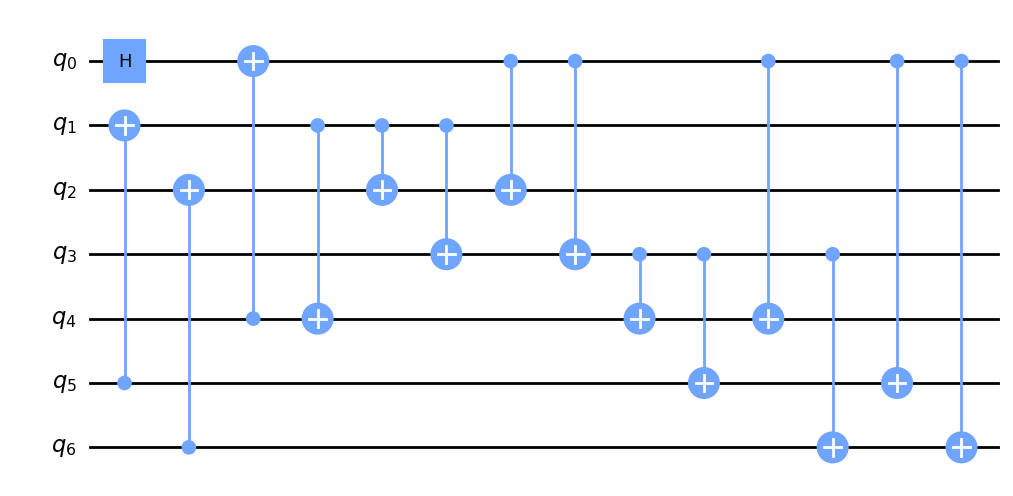

In [32]:
from qiskit.providers.fake_provider import FakeNairobiV2
backend = FakeNairobiV2()
circuit = QuantumCircuit(7)
circuit.h(0)
circuit.cx(4, 0)
circuit.cx(5, 1)
circuit.cx(6, 2)
circuit.cx(1, 4)
circuit.cx(1, 2)
circuit.cx(1, 3)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(3, 4)
circuit.cx(3, 5)
circuit.cx(3, 6)
circuit.cx(0, 4)
circuit.cx(0, 5)
circuit.cx(0, 6)
circuit.draw('mpl')

Depth: 28
Number of swaps: 24


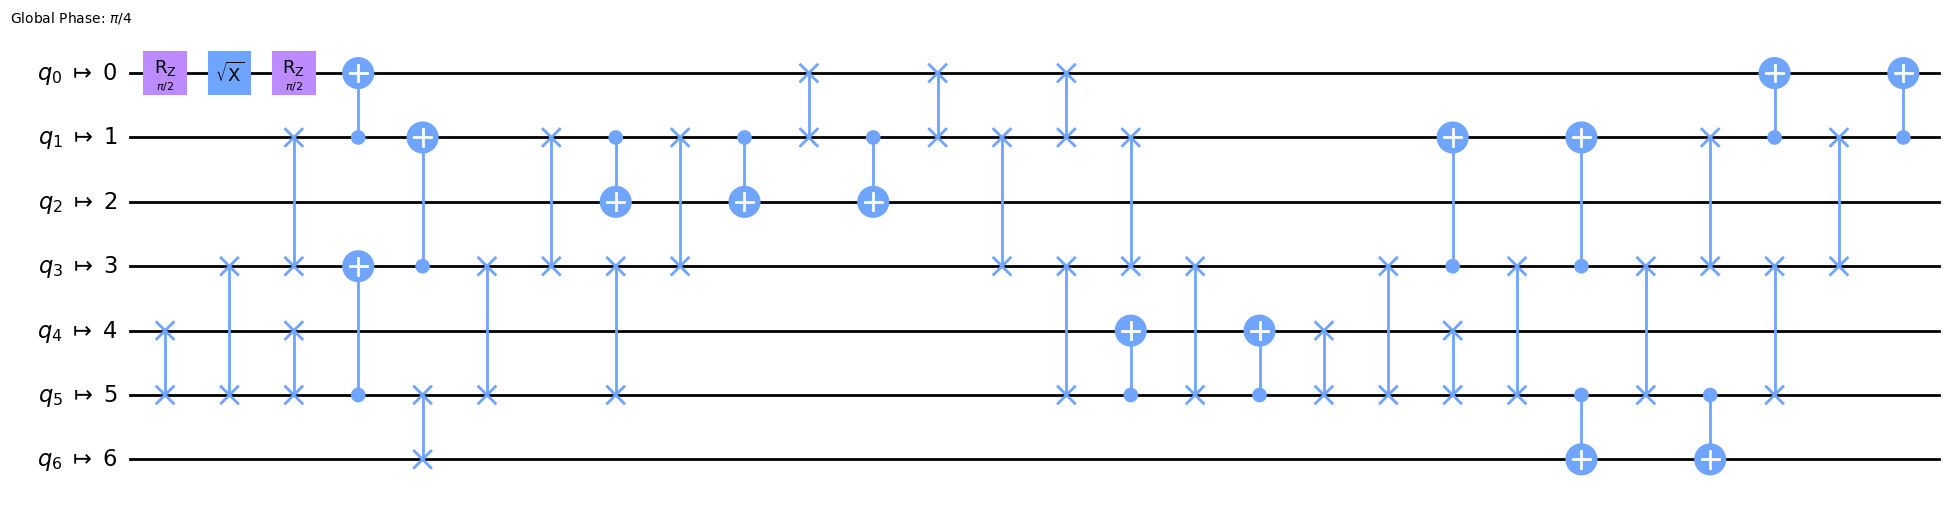

In [33]:
# Basic swap routing method
res = transpile(circuit, backend, layout_method='trivial', routing_method='basic', basis_gates=backend.operation_names + ["swap"])
print(f"Depth: {res.depth()}")
print(f"Number of swaps: {res.count_ops()['swap']}")
res.draw('mpl', fold=-1)

Depth: 25
Number of swaps: 20


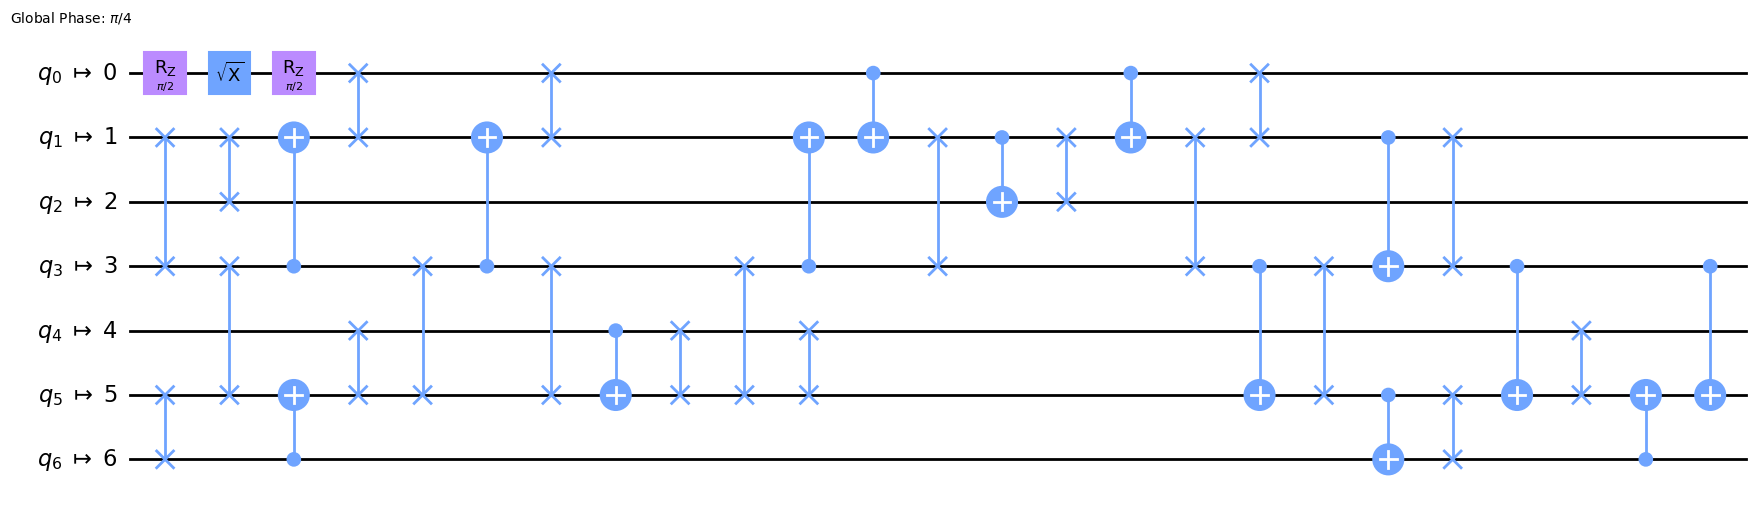

In [34]:
# Stochastic Swap routing method
res = transpile(circuit, backend, layout_method='trivial', routing_method='stochastic', basis_gates=backend.operation_names + ["swap"])
print(f"Depth: {res.depth()}")
print(f"Number of swaps: {res.count_ops()['swap']}")
res.draw('mpl', fold=-1)

Depth: 27
Number of swaps: 18


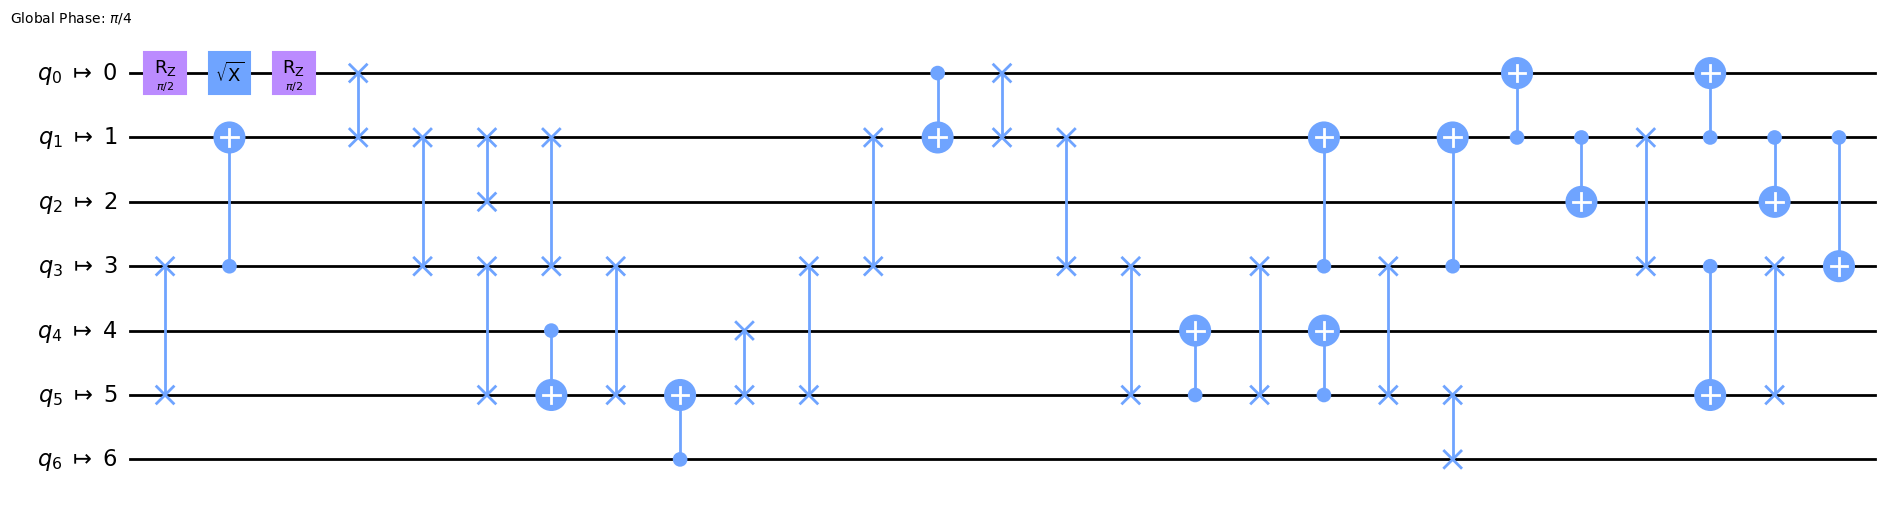

In [35]:
# Sabre swap routing method
res = transpile(circuit, backend, layout_method='trivial', routing_method='sabre', basis_gates=backend.operation_names + ["swap"])
print(f"Depth: {res.depth()}")
print(f"Number of swaps: {res.count_ops()['swap']}")
res.draw('mpl', fold=-1)

Depth: 22
Number of swaps: 16


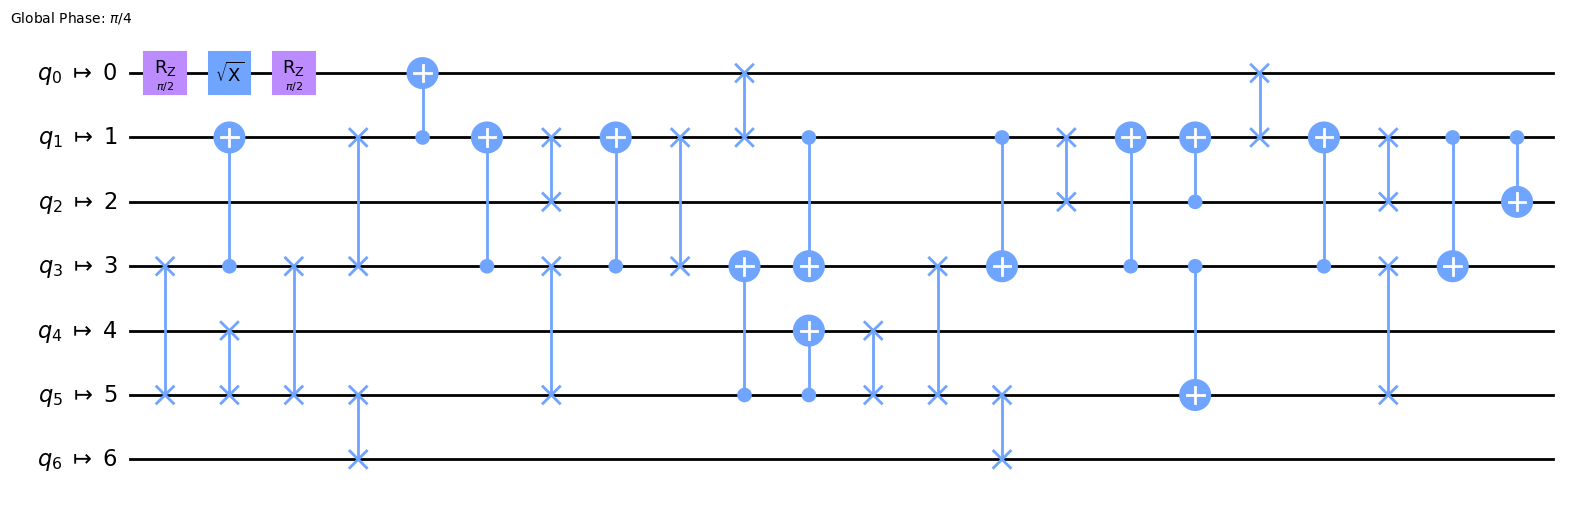

In [36]:
# Lookahead swap routing method
res = transpile(circuit, backend, layout_method='trivial', routing_method='lookahead', basis_gates=backend.operation_names + ["swap"])
print(f"Depth: {res.depth()}")
print(f"Number of swaps: {res.count_ops()['swap']}")
res.draw('mpl', fold=-1)

## Basis Translation

The translation stage is used to convert all the circuit operations from the input circuit into instructions supported on the target. There are 3 methods available to do this.

* `translator` - Uses a library of circuit equivalences to translate gates in circuit to target basis
* `synthesis` - Performs gate translation using unitary synthesis. Only works for some backend; if the target basis is supported by the synthesis routine. Typically far less efficient in runtime but potentially more efficient output in some cases
* `unroller` - Legacy tree decent using built in definitions. Do not use if basis is anything other that `u3`, `u2`, `u1`, `cx` (IBM hardware's legacy basis set) only exists for backwards compatibility

`translation_method` is used to select the translation method. But in general it is best to
stick with the `translator method` for best results.

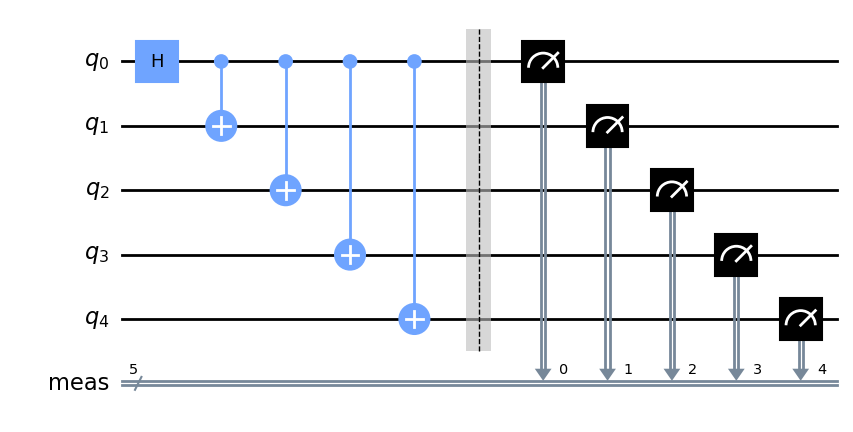

In [37]:
circuit = QuantumCircuit(5)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(0, 4)
circuit.measure_all()
circuit.draw('mpl')

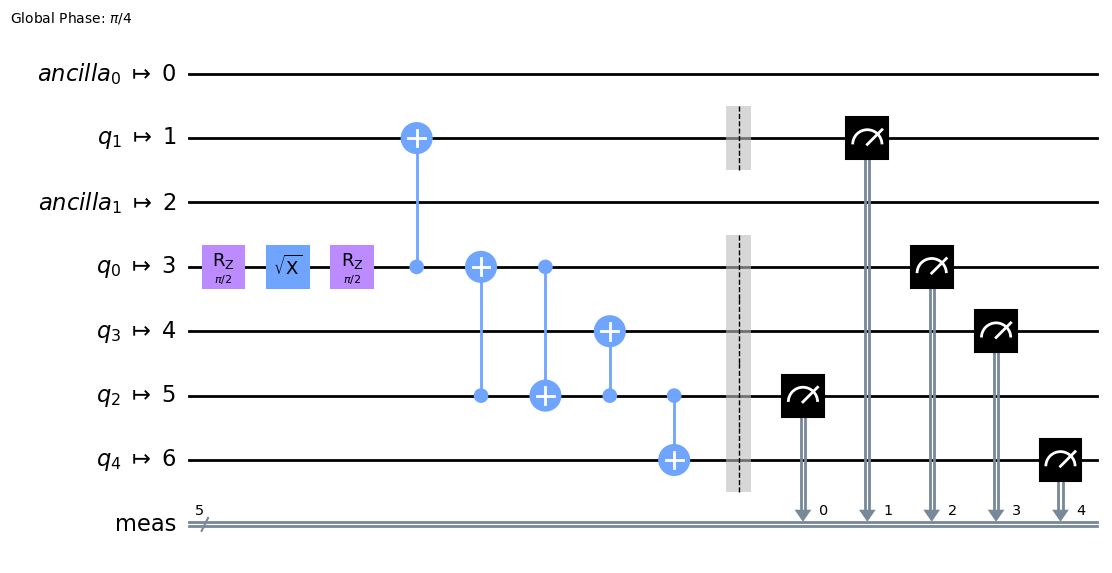

In [38]:
transpile(circuit, backend, translation_method='translator').draw('mpl')

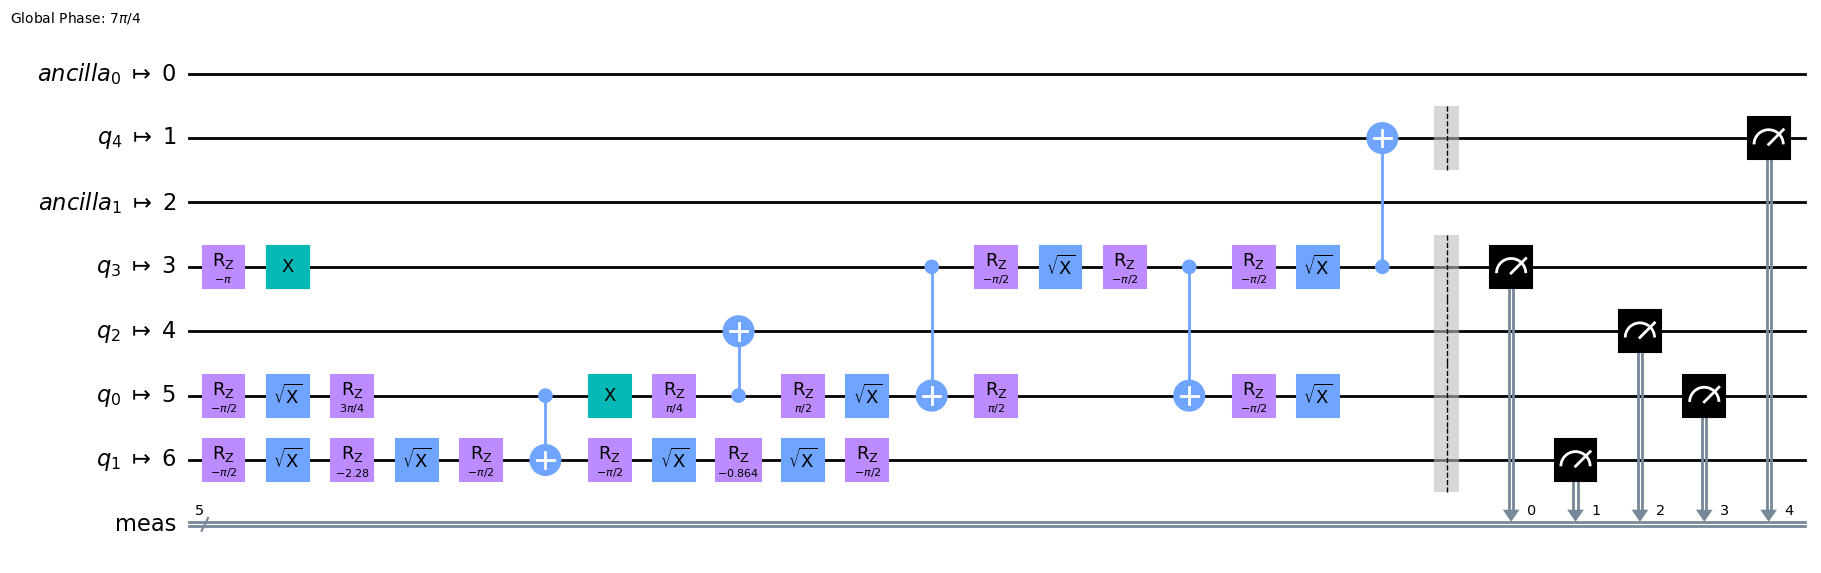

In [39]:
transpile(circuit, backend, translation_method='synthesis').draw('mpl', fold=-1)

In [40]:
from qiskit.exceptions import QiskitError
try:
    transpile(circuit, backend, translation_method='unroller')
except QiskitError:
    print('This will not work with a modern backend')

This will not work with a modern backend


## Adding rules for custom gates to equivalence library

If you're using custom gates not in Qiskit's standard library you will also need to add equivalence rules to the library so that the basis translator will be able to use it.

Typically an end user doesn't need to do this (as the backend should already do this in normal cases), unless they're defining custom gates with associated pulse schedules and want the transpiler to be able to use them.

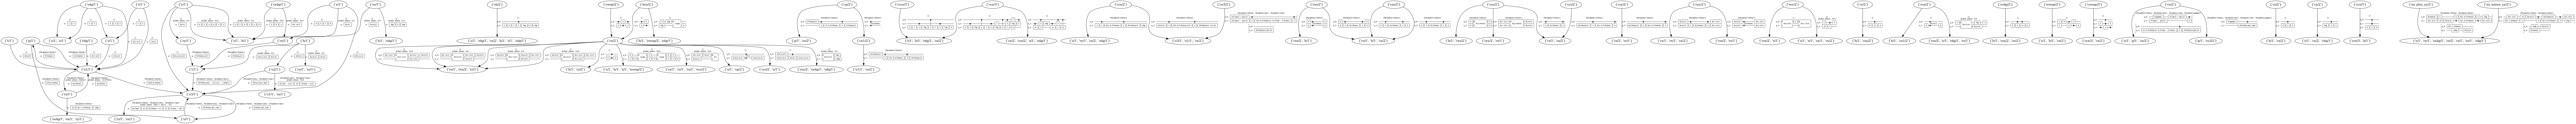

In [41]:
from qiskit.circuit import equivalence_library
equivalence_library.SessionEquivalenceLibrary.draw()

In [42]:
from qiskit.circuit.library import HGate
from qiskit.circuit.library import ZGate
from qiskit.circuit.library import RZGate
from qiskit.circuit.library import U2Gate
from qiskit.circuit import Gate

class SYGate(Gate):
    """Square root of Y gate"""
    def __init__(self, label=None):
        super().__init__("sy", 1, [], label=label)

    def _define(self):
        qc = QuantumCircuit(1)
        q.ry(np.pi / 2, 0)
        self.definition = qc

# H => Z SY
q = qiskit.QuantumRegister(1, "q")
def_sy_h = qiskit.QuantumCircuit(q)
def_sy_h.append(ZGate(), [q[0]], [])
def_sy_h.append(SYGate(), [q[0]], [])
equivalence_library.SessionEquivalenceLibrary.add_equivalence(
    HGate(), def_sy_h)

# u2 => Z SY Z
phi = qiskit.circuit.Parameter('phi')
lam = qiskit.circuit.Parameter('lambda')
q = qiskit.QuantumRegister(1, "q")
def_sy_u2 = qiskit.QuantumCircuit(q)
def_sy_u2.append(RZGate(lam), [q[0]], [])
def_sy_u2.append(SYGate(), [q[0]], [])
def_sy_u2.append(RZGate(phi), [q[0]], [])
equivalence_library.SessionEquivalenceLibrary.add_equivalence(
    U2Gate(phi, lam), def_sy_u2)

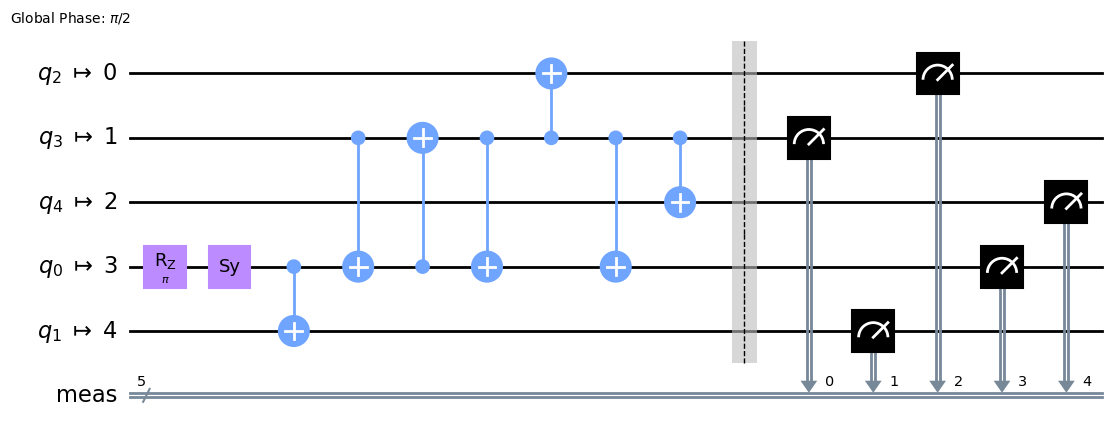

In [43]:
target = FakeBelemV2().target
target.add_instruction(SYGate(), {(i,): None for i in range(target.num_qubits)})

transpile(circuit, target=target).draw('mpl')

## Optimization

The optimization stage is configurable with the `optimization_method` argument, but by default there is only one method available and its behavior is adjusted by the `optimization_level` argument used.

There are many different methods for circuit optimization. There are 3 primary ones we'll discuss here:

* `Optimize1qGatesDecomposition`
* `ComutativeCancelation`
* `Collect2qBlocks`, `ConsolidateBlocks`, and `UnitarySynthesis`

### 1 Qubit Gate Optimization

This optimization finds isolated runs of single qubit gates

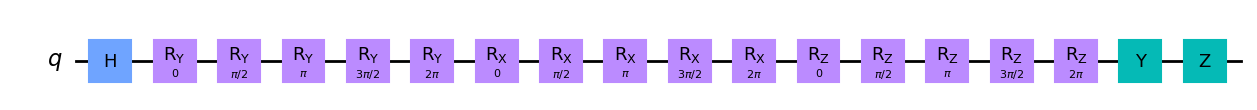

In [44]:
from math import pi
from qiskit.transpiler.passes import Optimize1qGatesDecomposition

optimizer = Optimize1qGatesDecomposition(target=backend.target)
qc = QuantumCircuit(1)
qc.h(0)
for i in range(5):
    qc.ry((i * pi) / 2, 0)
for i in range(5):
    qc.rx((i * pi) / 2, 0)
for i in range(5):
    qc.rz((i * pi) / 2, 0)
qc.y(0)
qc.z(0)
qc.draw('mpl')

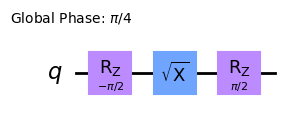

In [45]:
optimizer(qc).draw('mpl')

In [46]:
import pprint
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
runs = dag.collect_1q_runs()
pprint.pprint(runs)

[[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[0.0]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[3.141592653589793]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[4.71238898038469]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[6.283185307179586]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=()),
  DAGOpNode(op=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.0]), qargs=(Qubit(QuantumRegister(1, 'q'), 0),), cargs=(

In [47]:
from qiskit.quantum_info import Operator
op = Operator(qc)
print(op)

Operator([[ 4.19662513e-16+0.70710678j,  1.35448999e-16-0.70710678j],
          [ 1.35448999e-16+0.70710678j, -4.19662513e-16+0.70710678j]],
         input_dims=(2,), output_dims=(2,))


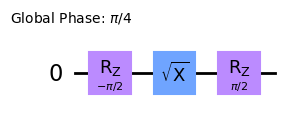

In [48]:
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
synthesis = OneQubitEulerDecomposer(basis='ZSX')
simplified = synthesis(op)
simplified.draw('mpl')

## Commutative Cancellation

Cancel redudant operations through commutation

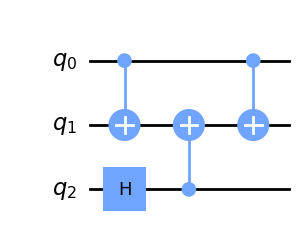

In [49]:
circuit = QuantumCircuit(3)
circuit.cx(0, 1)
circuit.h(2)
circuit.cx(2, 1)
circuit.cx(0, 1)
circuit.draw('mpl')

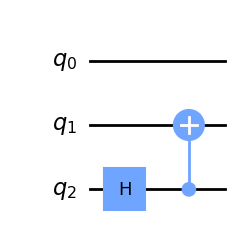

In [50]:
from qiskit.transpiler.passes import CommutativeCancellation
from qiskit.transpiler import PassManager

pm = PassManager(CommutativeCancellation())
pm.run(circuit).draw('mpl')

# 2 qubit block optimization

This optimization finds blocks of operations on 2 qubits and resynthesizes them to use less gates.

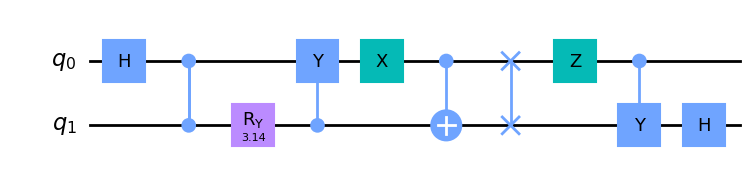

In [51]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cz(0, 1)
circuit.ry(3.14159, 1)
circuit.cy(1, 0)
circuit.x(0)
circuit.cx(0, 1)
circuit.swap(1, 0)
circuit.z(0)
circuit.cy(0, 1)
circuit.h(1)
circuit.draw('mpl')

[[ 6.63397448e-07-5.00000000e-01j -6.63397448e-07+5.00000000e-01j
   5.00000000e-01+6.63397448e-07j -5.00000000e-01-6.63397448e-07j]
 [ 5.00000000e-01+6.63397448e-07j  5.00000000e-01+6.63397448e-07j
   6.63397448e-07-5.00000000e-01j  6.63397448e-07-5.00000000e-01j]
 [ 6.63397448e-07+5.00000000e-01j -6.63397448e-07-5.00000000e-01j
   5.00000000e-01-6.63397448e-07j -5.00000000e-01+6.63397448e-07j]
 [-5.00000000e-01+6.63397448e-07j -5.00000000e-01+6.63397448e-07j
  -6.63397448e-07-5.00000000e-01j -6.63397448e-07-5.00000000e-01j]]


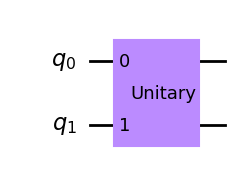

In [52]:
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks
pm = PassManager([Collect2qBlocks(), ConsolidateBlocks(target=backend.target)])
blocks = pm.run(circuit)
print(blocks.data[0].operation.params[0])
blocks.draw('mpl')

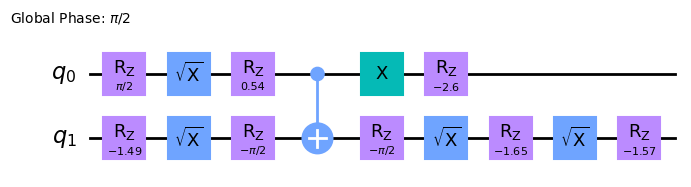

In [53]:
from qiskit.transpiler.passes import UnitarySynthesis
UnitarySynthesis(target=backend.target)(blocks).draw('mpl')

## Scheduling

The scheduling stage is used to schedule the circuit so that all slack time in the execution of the circuit is accounted for. Included by default with Qiskit are two methods:

* `"alap"` - As late as possible scheduling
* `"asap"` - As soon as possible scheduling

The `scheduling_method` argument is used to specify which scheduling method.

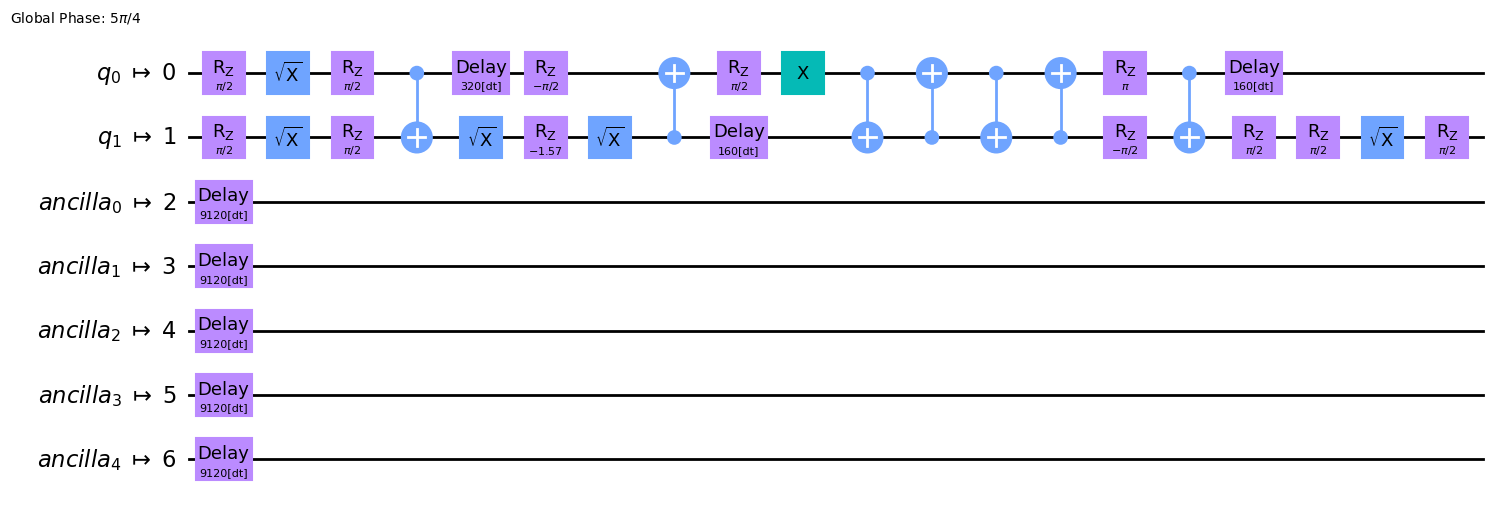

In [54]:
transpile(circuit, backend, scheduling_method='alap').draw('mpl')

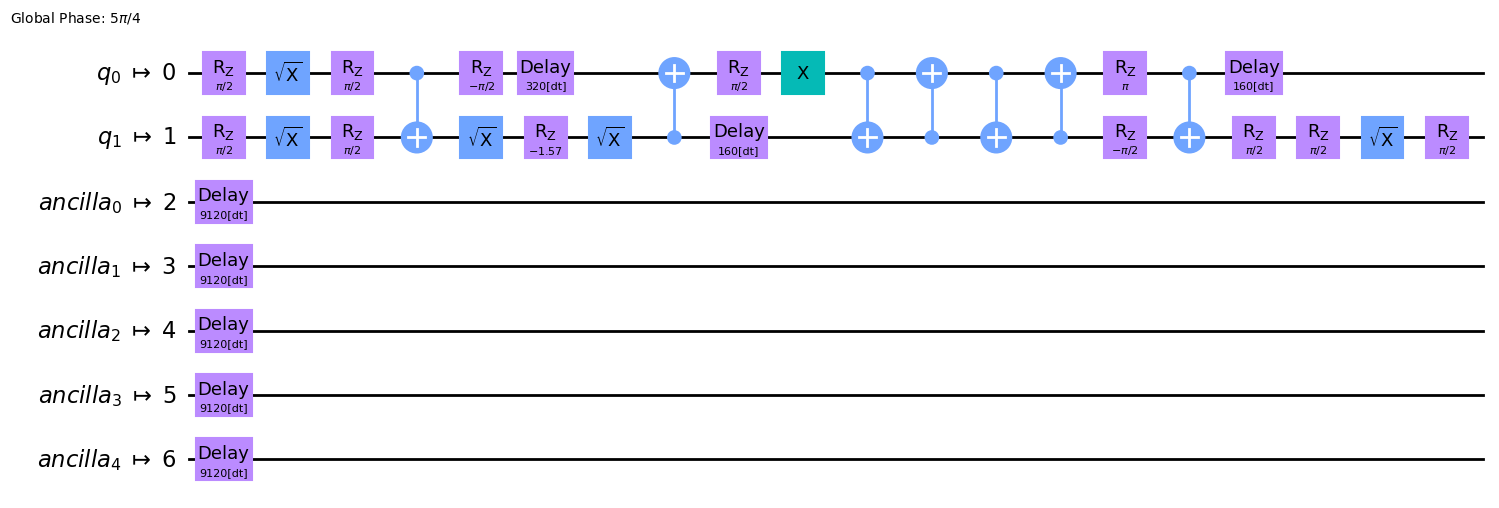

In [55]:
transpile(circuit, backend, scheduling_method='asap').draw('mpl')

## How `transpile()` works internally

## DAG Circuit

* Intermediate representation inside Qiskit's compiler.
* Similar to a data flow graph in classical compilers.
* Nodes represent input (bits at circuit start), output (bits at circuit end), and operations
* Edges indicate data flow between nodes
* Models flow of data on qubits and classical bits via operations

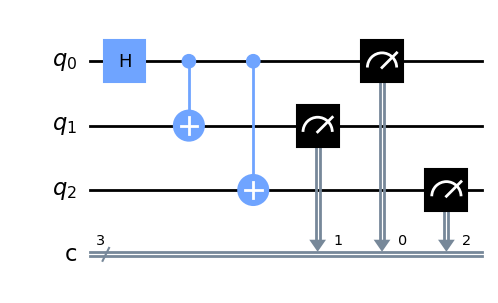

In [56]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
for i in range(3):
    circuit.measure(i, i)
circuit.draw('mpl')

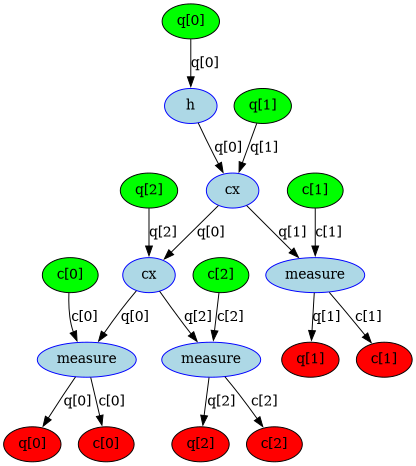

In [57]:
dag = circuit_to_dag(circuit)
dag.draw()

This data structure makes it much easier to analyze the data dependency between operations, which is useful for many types of passes. For example, in 2q optimization collecting the bots:

![block_collection.png](imgs/block_collection.png)

## Passes

The transpiler internally is broken up into a passes which are functions that

![passmanager_2.png](imgs/passmanager_2.png)

## Pass Managers

![passmanager.png](imgs/passmanager.png)

## Contents of Preset Pass Managers

In [58]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

### Optimization Level 0

* No optimization, designed to do minimal effort to just map input circuit to hardware constraints.
* Typically only used for characterization experiments
* Runs `TrivialLayout` (which maps virtual circuit qubit 0 -> physical qubit 0, 1->1, 2->2, etc).
* Runs `StochasticSwap` routing pass
* Runs the `BasisTranslator` to convert to the native instructions

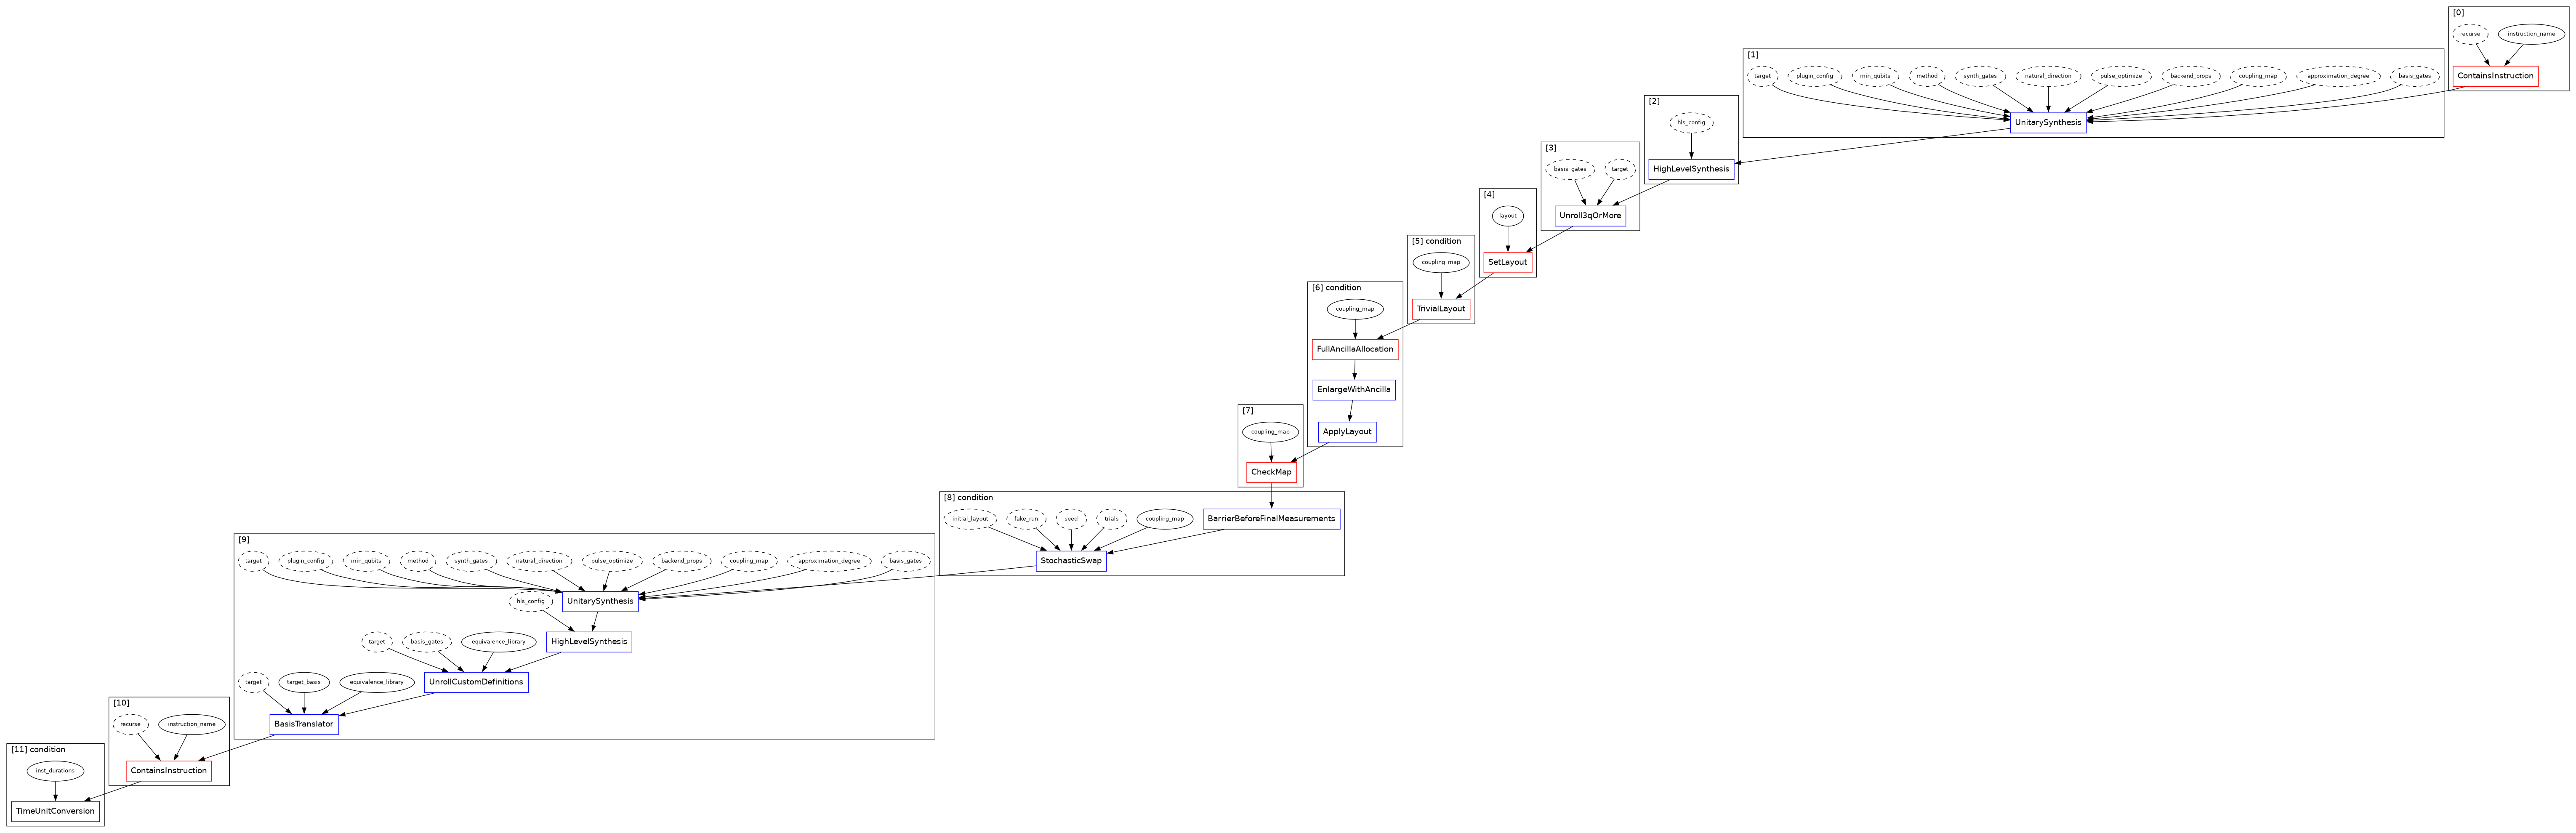

In [59]:
level_0 = generate_preset_pass_manager(0, backend)
level_0.draw()

### Optimization Level 1

* Runs `TrivialLayout` -> `VF2Layout` -> `SabreLayout` trying each pass in succession and if a perfect layout is found the later passes are skipped
* Runs `SabreSwap` for routing
* Runs `VF2PostLayout` after routing
* Runs the `BasisTranslator` to convert to the native instructions
* For the optimization loop it runs 1q gate optimization and CX cancellation (finds runs of CX gates and cancels them out to mod 2)
* Optimization loop runs until it reaches fixed point in depth and size between 2 iterations

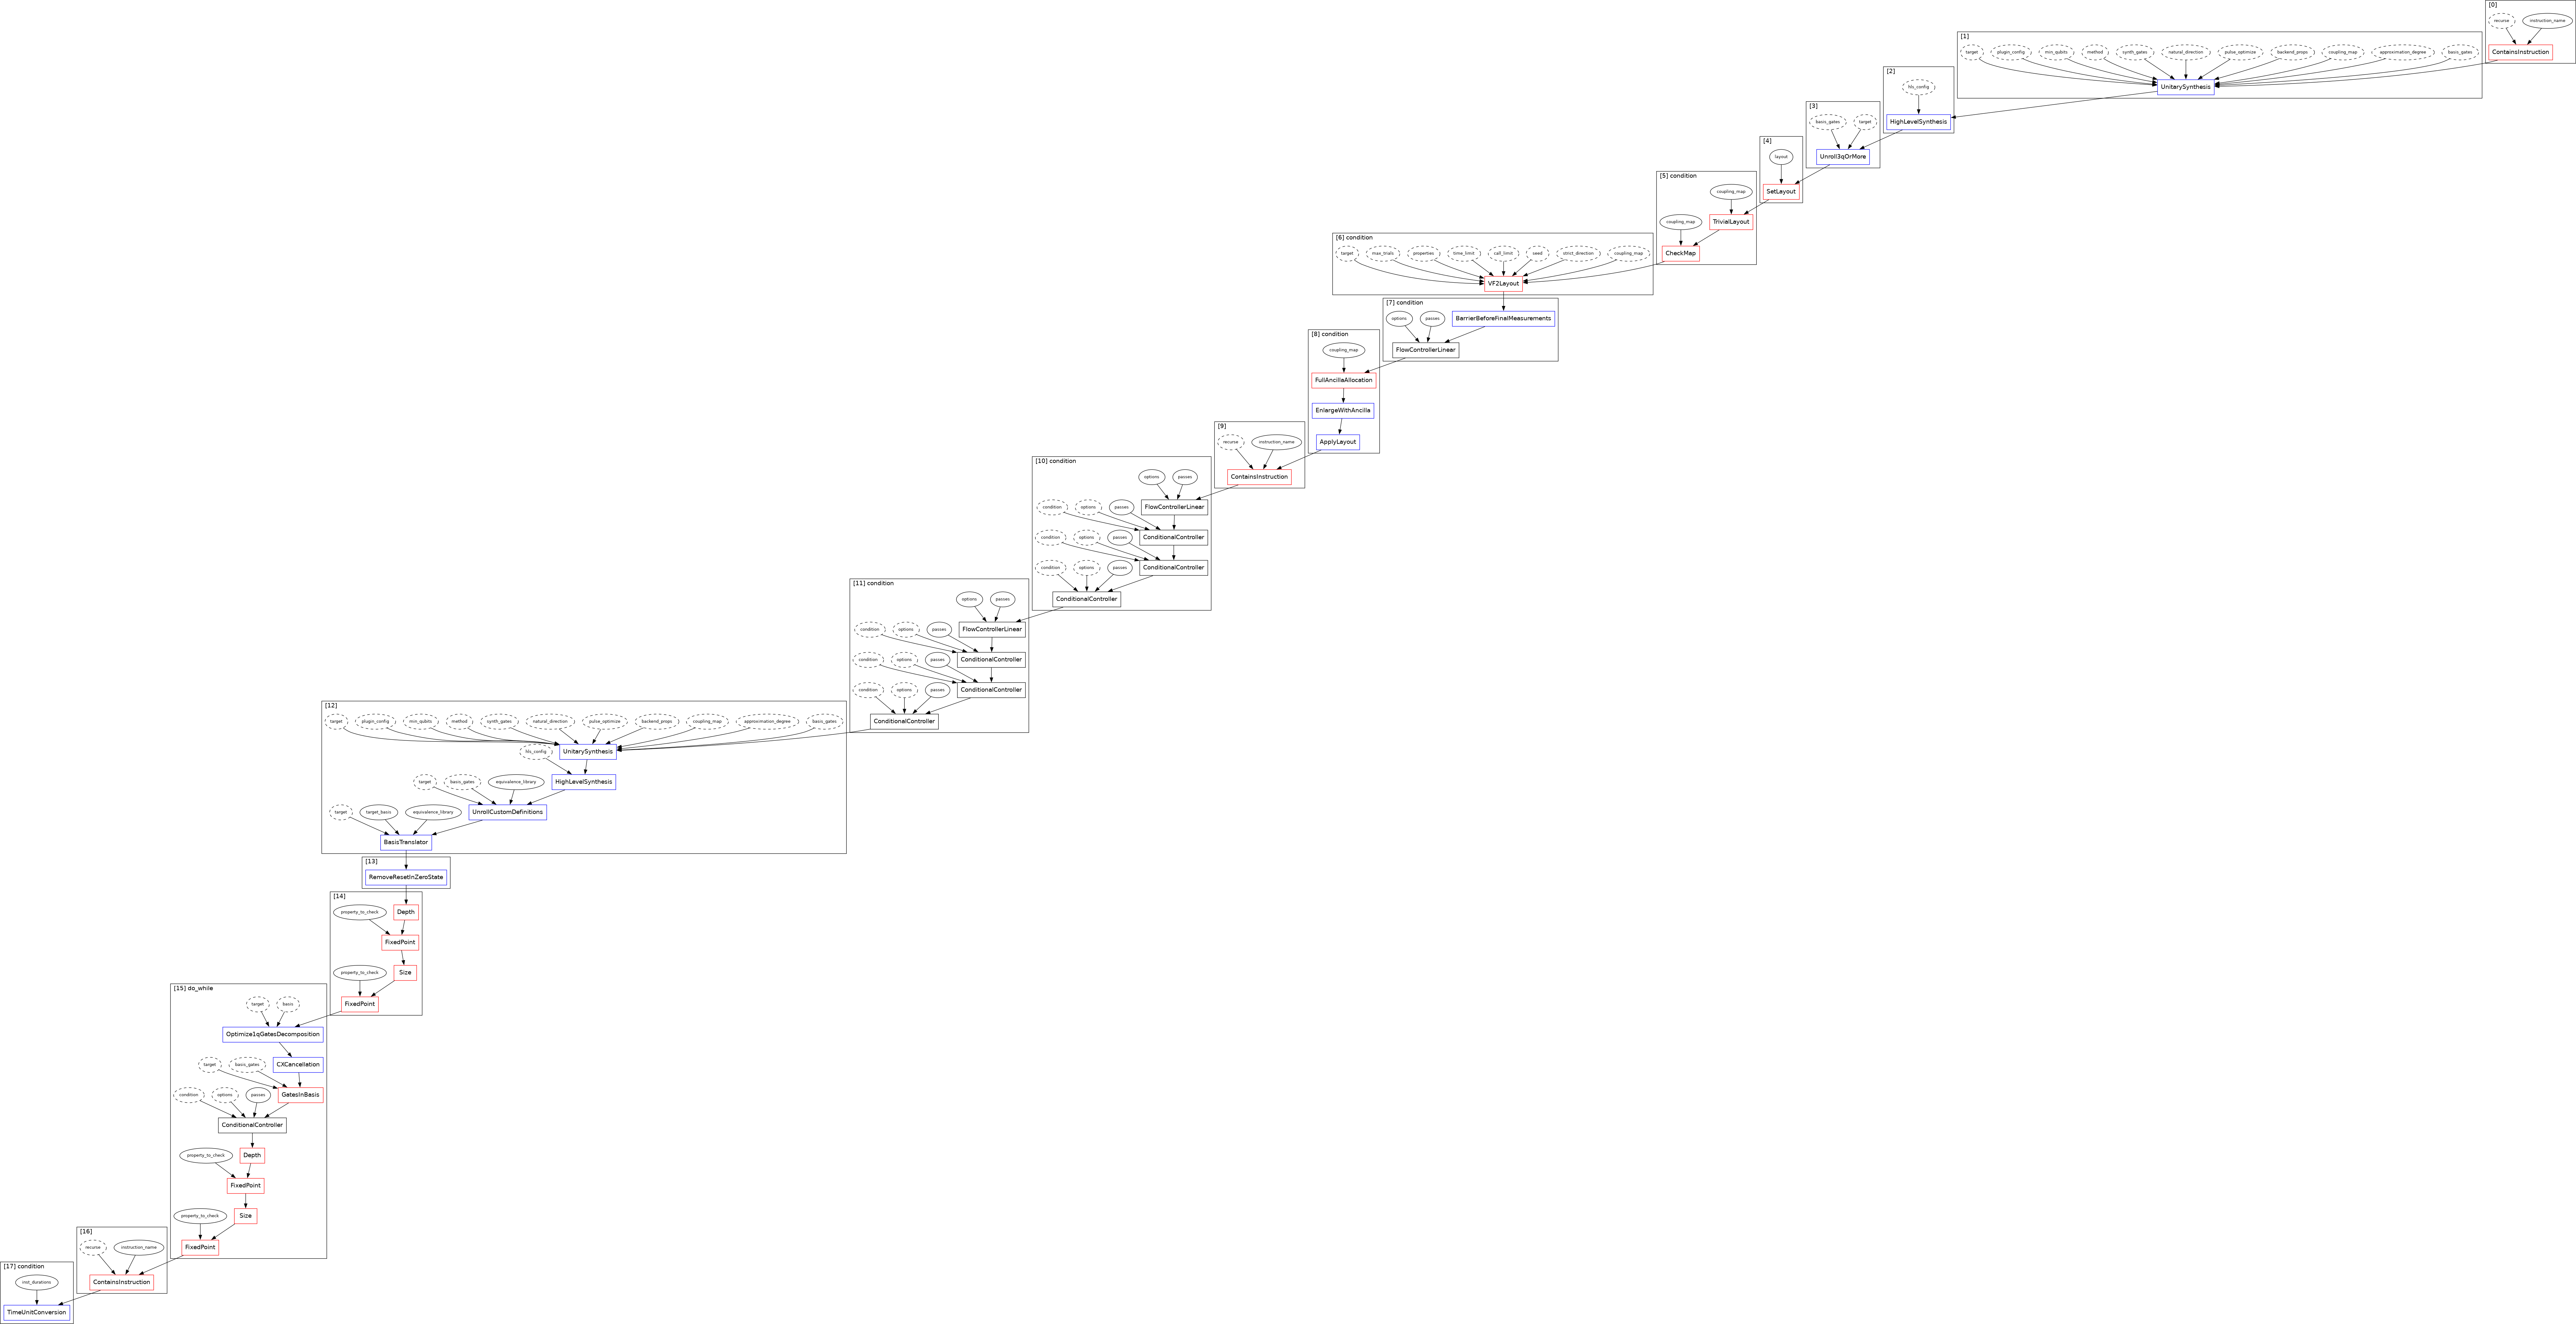

In [60]:
level_1 = generate_preset_pass_manager(1, backend)
level_1.draw()

## Optimization Level 2

* `VF2Layout` -> `SabreLayout` if VF2Layout can't find a solution `SabreLayout` is used
* Number of random trials for VF2 and Sabre are increased over Level 1
* Runs `SabreSwap` for routing
* Runs `VF2PostLayout` after routing
* Runs the `BasisTranslator` to convert to the native instructions
* For the optimization loop it runs 1q gate optimization and commutative cancellation (which replaces CX cancellation)

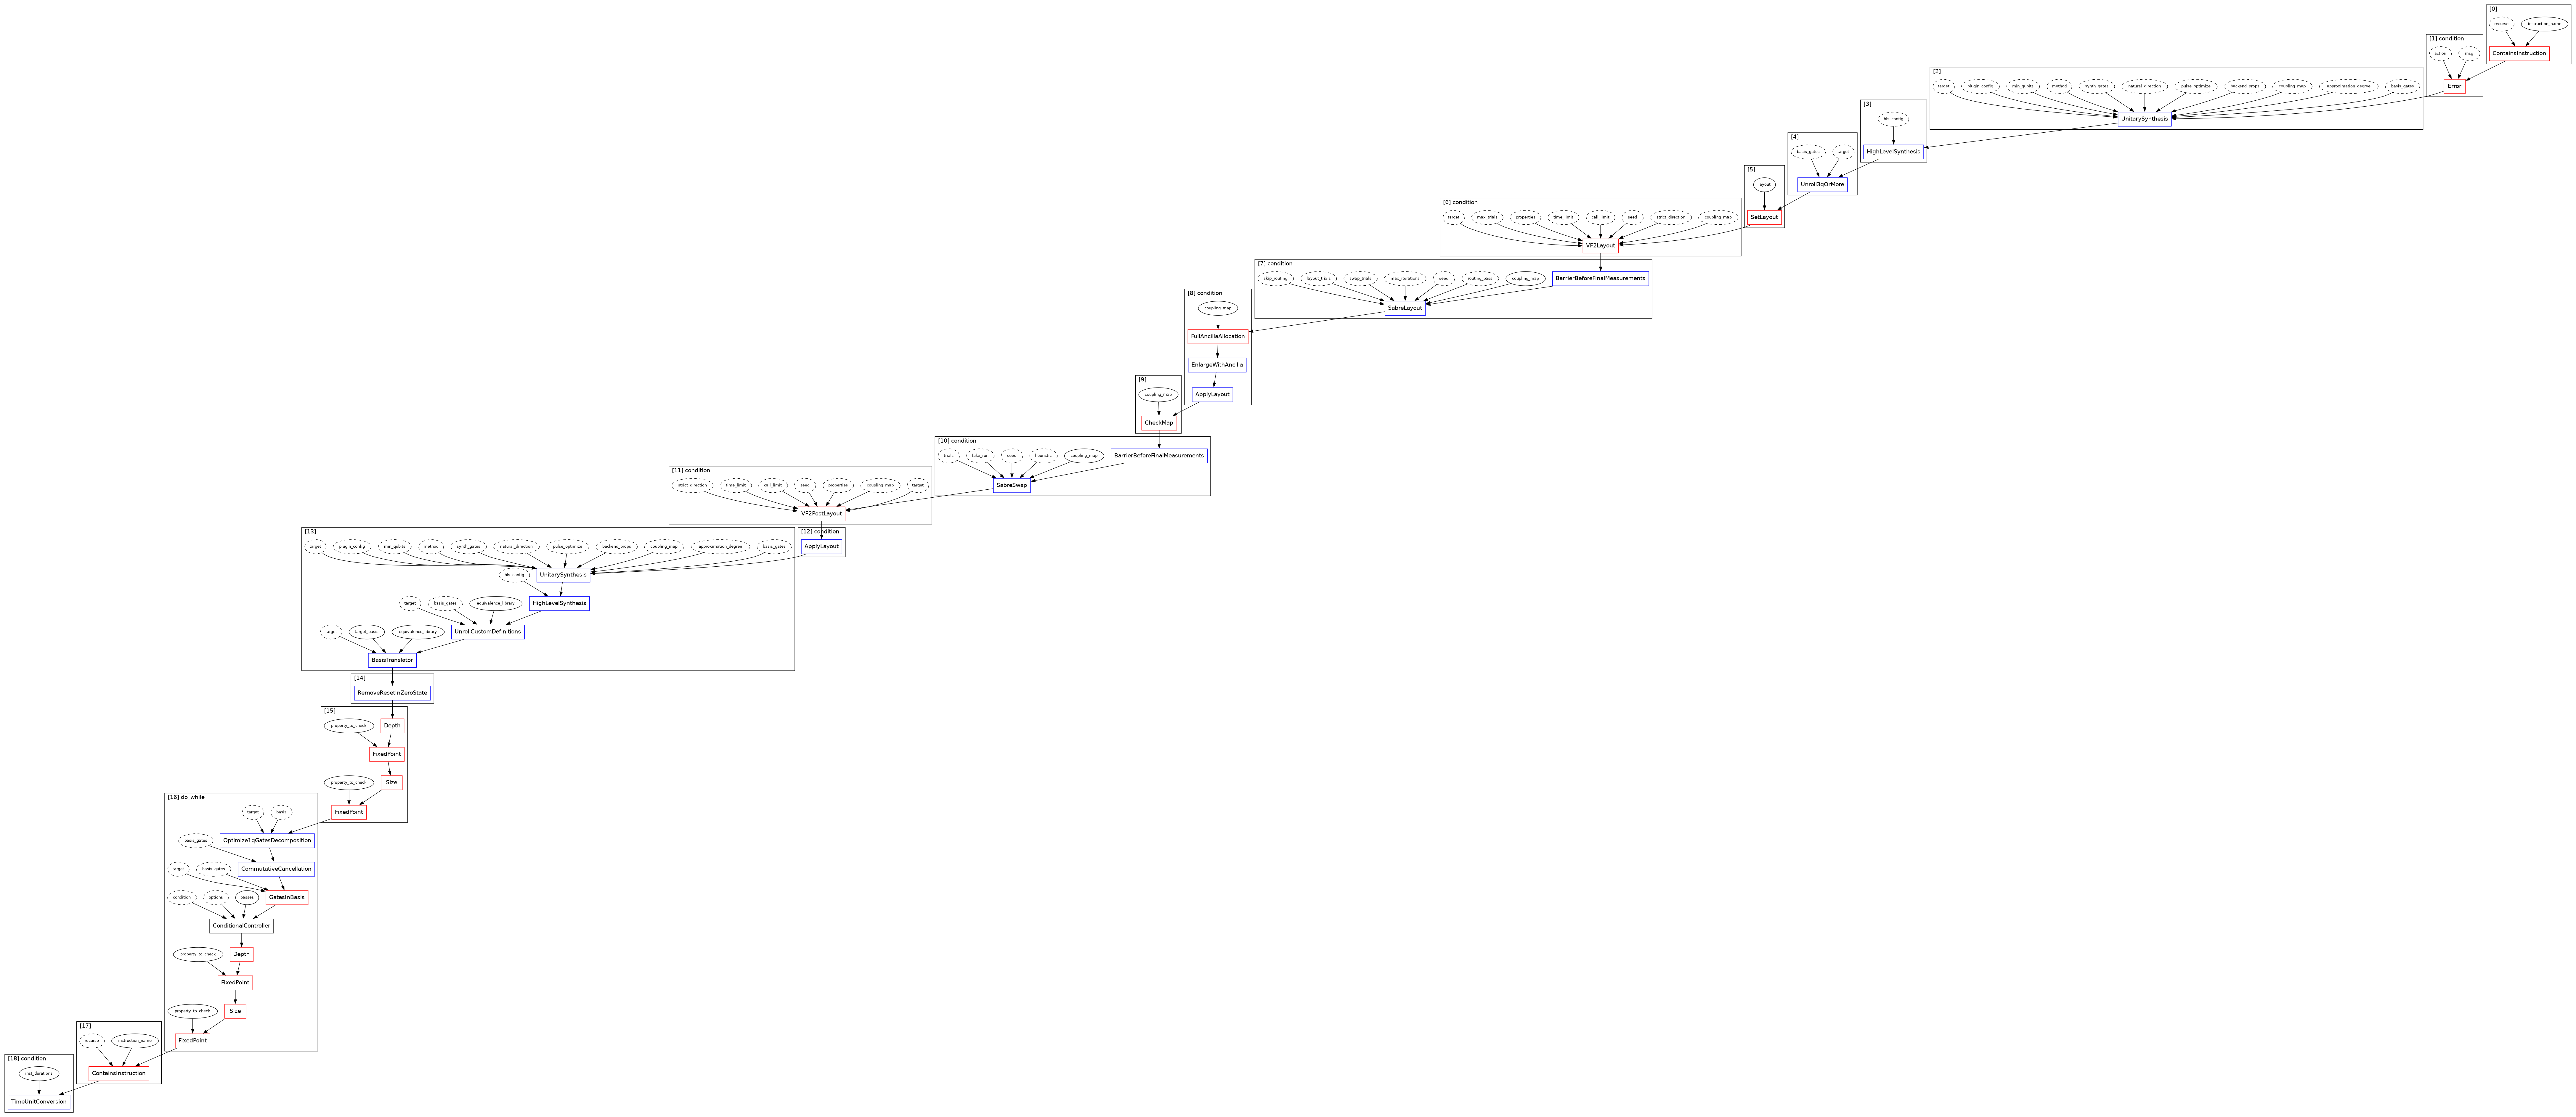

In [61]:
level_2 = generate_preset_pass_manager(2, backend)
level_2.draw()

## Optimization Level 3

* `VF2Layout` -> `SabreLayout` if VF2Layout can't find a solution `SabreLayout` is used
* Runs `SabreSwap` for routing
* Runs `VF2PostLayout` after routing
* Number of random trials for VF2 and Sabre are increased over Level 2
* Runs the `BasisTranslator` to convert to the native instructions
* Logical optimization runs in `init` to remove superfluous operations at front and end of circuit
* For the optimization loop it runs 1q gate optimization, 2q block optimization and commutative cancellation

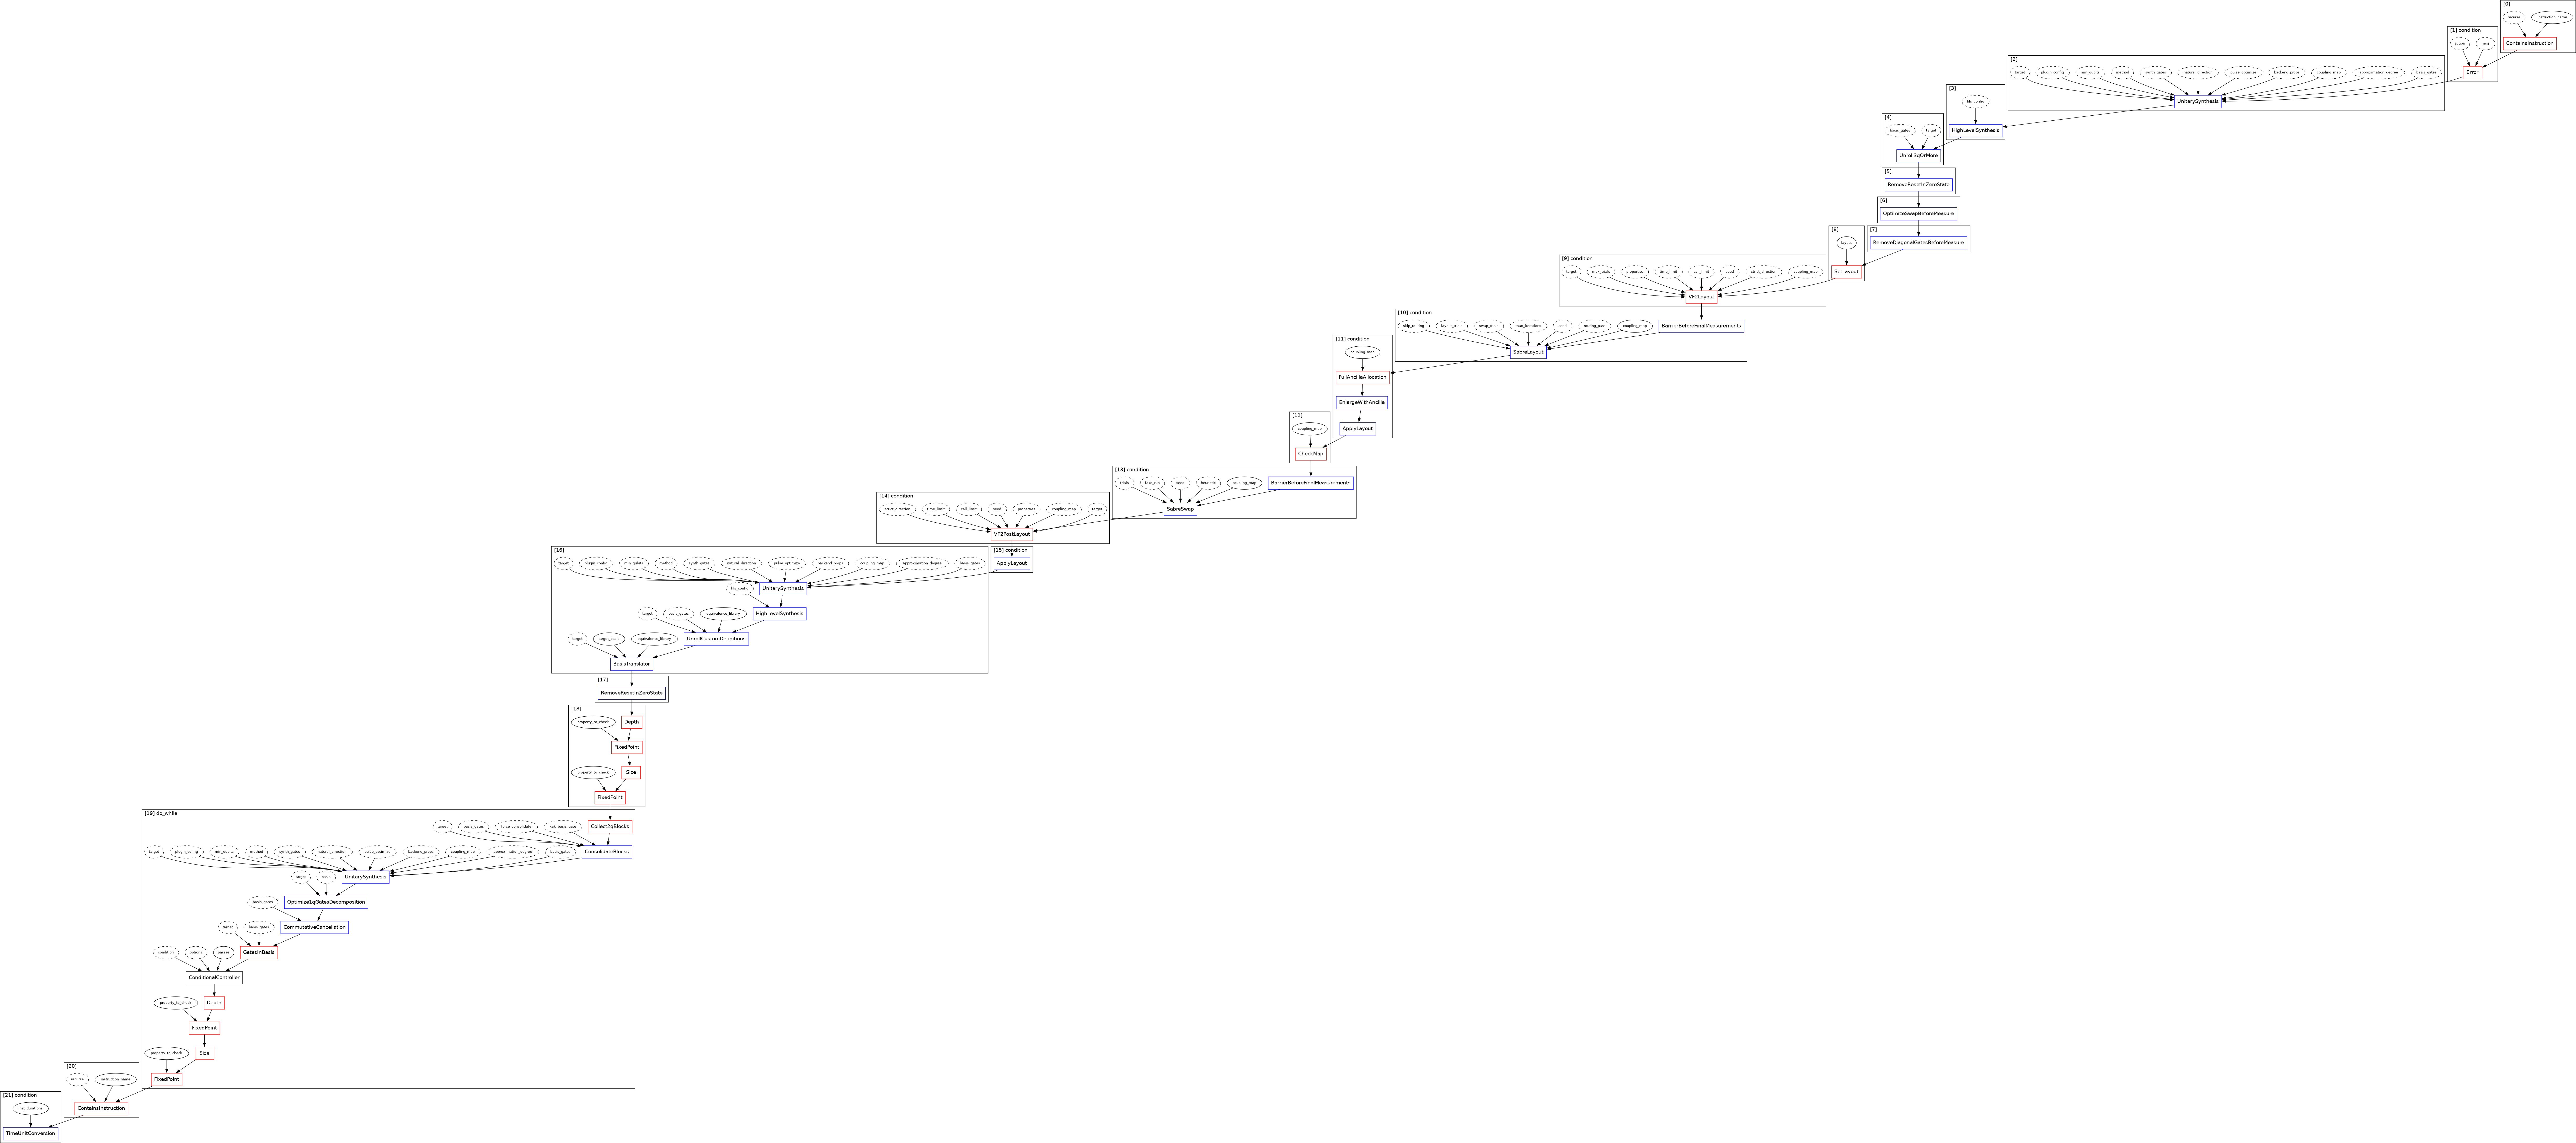

In [62]:
level_3 = generate_preset_pass_manager(3, backend)
level_3.draw()

## Conclusions

* Quantum circuit compilation is necessary for running
* Qiskit's `transpile()` function is primary entry point for compiling circuits
* It maps and optimizes input circuits to run on hardware
* There are numerous options built-in to customize the behavior

### Part 2 Tomorrow

We'll look at how we can create custom compilation workflows for different applications.